## Collaudo

In [90]:
## Verificare che:
# il kernel in Jupyter punti davvero al tuo venv nuovo (~/tfmetal310/bin/python),
# TensorFlow sia installato e funzioni,
# la GPU Metal sia riconosciuta (/physical_device:GPU:0 deve comparire nella lista).

import sys, platform, tensorflow as tf
print(sys.executable)  # mostra quale interprete Python stai usando
print("Python:", platform.python_version())  # versione Python
print("TF:", tf.__version__)  # versione TensorFlow
print("GPU:", tf.config.list_physical_devices("GPU"))  # elenca le GPU viste da TF

/Users/vittoriostile/tfmetal310/bin/python
Python: 3.11.5
TF: 2.16.1
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [91]:
## Verifiche successive:
# abilitare automaticamente la mixed precision (mixed_float16) se c’è la GPU, così sfrutti al massimo Apple Silicon (più veloce e con meno memoria),
# altrimenti resta su float32 (CPU fallback),
# stampare la policy effettiva usata.

from tensorflow.keras import mixed_precision
if tf.config.list_physical_devices("GPU"):
    mixed_precision.set_global_policy("mixed_float16")
else:
    mixed_precision.set_global_policy("float32")
print("Policy:", mixed_precision.global_policy().name)

Policy: mixed_float16


In [92]:
# Mini test di training per confermare che tutto gira

import tensorflow as tf, time

inp = tf.random.uniform([64, 224, 224, 3])
y   = tf.random.uniform([64], maxval=10, dtype=tf.int32)

m = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(10)
])
m.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

t0 = time.time()
m.fit(inp, y, epochs=2, batch_size=32, verbose=1)
print("Elapsed:", round(time.time()-t0, 2), "s")


Epoch 1/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.1094 - loss: 8.2047
Epoch 2/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.1094 - loss: 7.9458
Elapsed: 1.54 s


In [93]:
# --- Mixed precision e utilità veloci ---

# Abilita mixed precision su Apple (Metal) se c'è un acceleratore
if tf.config.list_physical_devices("GPU"):
    mixed_precision.set_global_policy("mixed_float16")
    print("Mixed precision:", mixed_precision.global_policy().name)
else:
    print("Mixed precision disattivata (no GPU visibile)")


Mixed precision: mixed_float16


## Conta i file nelle directory specificate REAL e FAKE

In [154]:
from pathlib import Path
import glob

def count_images(directory):
    """Conta tutti i file immagine in una directory e sottodirectory"""
    path = Path(directory)
    if not path.exists():
        print(f"[WARN] Directory non trovata: {directory}")
        return 0
        
    # Conta file con estensioni comuni di immagini
    count = 0
    for ext in ["*.jpg", "*.jpeg", "*.png"]:
        count += len(list(path.rglob(ext)))
        count += len(list(path.rglob(ext.upper())))
    return count

# Conta immagini nelle directory REAL e FAKE
real_count = count_images(REAL_FACES_PATH)
fake_count = count_images(FAKE_FACES_PATH)

print("\nConteggio immagini:")
print(f"REAL: {real_count:,} files")
print(f"FAKE: {fake_count:,} files")
print(f"TOTALE: {real_count + fake_count:,} files")

# Opzionale: mostra anche struttura directory
print("\nStruttura directories:")
for path in [REAL_FACES_PATH, FAKE_FACES_PATH]:
    if Path(path).exists():
        n_subdir = len(list(Path(path).glob("*/")))
        print(f"{path}: {n_subdir} subdirectories")


Conteggio immagini:
REAL: 28,483 files
FAKE: 28,051 files
TOTALE: 56,534 files

Struttura directories:
/Volumes/Macintosh SSD/FaceForensics_c40/original_sequences/youtube/c40/faces: 0 subdirectories
/Volumes/Macintosh SSD/FaceForensics_c40/manipulated_sequences/Deepfakes/c40/faces: 0 subdirectories


## Codice

In [155]:
# --- 1 Import & Config ---

# --- CONFIG DI BASE ---
REAL_FACES_PATH = "/Volumes/Macintosh SSD/FaceForensics_c40/original_sequences/youtube/c40/faces"
FAKE_FACES_PATH = "/Volumes/Macintosh SSD/FaceForensics_c40/manipulated_sequences/Deepfakes/c40/faces"
LABELS_CSV     = "/Volumes/Macintosh SSD/Developer/ground-truth_plus_auto-labeling-real_fake.csv"
CSV_PATH = "/Volumes/Macintosh SSD/Developer/ground-truth_plus_auto-labeling-real_fake.csv" 

# Task
N_TOTAL     = 20000
SEED          = 42
IMG_SIZE      = 224
BATCH_SIZE    = 32
EPOCHS        = 5
LR            = 1e-4
FREEZE_UNTIL  = "block4_pool"   # "none" per fine-tuning completo
CACHE_STRATEGY= "ram"           # "ram" | "disk" | "none"
MODEL_DIR     = "./models"
TRAIN_RATIO, VAL_RATIO, TEST_RATIO = 0.72, 0.14, 0.14

# Esclusioni (ognuna è una lista di valori da escludere per quella colonna)
# Esempi: {"gender": ["FEMALE"], "hair_color": ["BLONDE","RED"], "is_ears_visible": ["0"]}
EXCLUDE = {}   # <= riempi qui per esperimenti, es. {"gender":["FEMALE"]} o EXCLUDE = {"ethnicity": ["ASIAN", "AFRICAN", "MIXED", "OTHER"]}


# ---- NON TOCCARE SOTTO (a meno che tu sappia cosa fai) ----
import os, re, time, json, math, random, pathlib, itertools
from pathlib import Path
import numpy as np, pandas as pd

# TensorFlow SNAPPY
os.environ.setdefault("TF_CPP_MIN_LOG_LEVEL","2")
os.environ.setdefault("TF_GPU_THREAD_MODE","gpu_private")

import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import layers, models, callbacks, optimizers

from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             precision_recall_fscore_support, accuracy_score)

AUTOTUNE = tf.data.AUTOTUNE
IMG_EXTS = (".jpg",".jpeg",".png",".webp")

print("Python:", tf.sysconfig.get_build_info().get('python_version', ''))
print("TF:", tf.__version__)
print("GPU devices:", tf.config.list_physical_devices("GPU"))


Python: 
TF: 2.16.1
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [176]:
# === Config di esperimento ===
from pathlib import Path
import os, json, time, numpy as np, pandas as pd

SEED = 42
N_TOTAL = 50000
TRAIN_RATIO, VAL_RATIO, TEST_RATIO = 0.72, 0.14, 0.14

# Percorsi dati (frames)
REAL_FACES_PATH = "/Volumes/Macintosh SSD/FaceForensics_c40/original_sequences/youtube/c40/faces"
FAKE_FACES_PATH = "/Volumes/Macintosh SSD/FaceForensics_c40/manipulated_sequences/Deepfakes/c40/faces"

# Percorso CSV etichette video
CSV_PATH = "/Volumes/Macintosh SSD/Developer/ground-truth_plus_auto-labeling-real_fake.csv" 

# Export artefatti (writable)
EXPORT_DIR = Path("/Volumes/Macintosh SSD/Developer/exports")
EXPORT_DIR.mkdir(parents=True, exist_ok=True)

# Esclusioni (facoltative)
EXCLUDE = {"gender": ["FEMALE"]}  # <= riempi qui per esperimenti,
  # es: {"gender": ["MALE"]} o EXCLUDE = {"ethnicity": ["ASIAN", "AFRICAN"]}

excl_used = "_".join([f"{k}-{','.join(v)}" for k,v in EXCLUDE.items()]) if EXCLUDE else "none"


In [167]:
# === Lettura CSV etichette (separatore ';') e normalizzazione nomi/valori ===
df_labels = pd.read_csv(CSV_PATH, sep=";")

# Rinomina eventuali colonne
rename_map = {
    "video_name": "video_id",
    "hair_lenght": "hair_length",  # fix typo
}
df_labels = df_labels.rename(columns=rename_map)

# Normalizza video_id togliendo .mp4
if "video_id" in df_labels.columns:
    df_labels["video_id"] = df_labels["video_id"].astype(str).str.replace(".mp4", "", regex=False)

# Uniforma bool a 0/1 se presente
if "is_ears_visible" in df_labels.columns:
    df_labels["is_ears_visible"] = (
        df_labels["is_ears_visible"]
        .astype(str)
        .str.strip()
        .str.upper()
        .map({"1":1,"0":0,"TRUE":1,"FALSE":0,"YES":1,"NO":0})
        .fillna(0)
        .astype(int)
    )


In [177]:
# --- 3: Carica & normalizza etichette dal CSV separato da ';' ---

import pandas as pd

df_labels = pd.read_csv(LABELS_CSV, sep=";")

# rinomina il typo hair_lenght -> hair_length se presente
if "hair_lenght" in df_labels.columns:
    df_labels = df_labels.rename(columns={"hair_lenght": "hair_length"})

# rimuovi eventuale colonna is_real dal CSV: NON la usiamo
if "is_real" in df_labels.columns:
    df_labels = df_labels.drop(columns=["is_real"])

# video_id = video_name senza .mp4
df_labels["video_id"] = df_labels["video_name"].astype(str).str.replace(".mp4","", regex=False)

# normalizza stringhe testuali
for c in ["gender","ethnicity","hair_color","hair_length"]:
    if c in df_labels.columns:
        df_labels[c] = df_labels[c].astype(str).str.strip().str.upper()

# normalizza is_ears_visible -> int {0,1} (se manca, la creo a 0)
def to01(x):
    if pd.isna(x): return 0
    s = str(x).strip().upper()
    if s in ("TRUE","1","YES","Y"): return 1
    if s in ("FALSE","0","NO","N"): return 0
    # fallback: qualsiasi valore non vuoto diverso da 0/NO -> 1
    return 1 if s not in ("", "0", "FALSE", "NO", "N", "NONE") else 0

if "is_ears_visible" in df_labels.columns:
    df_labels["is_ears_visible"] = df_labels["is_ears_visible"].map(to01).astype(int)
else:
    df_labels["is_ears_visible"] = 0  # default

# tieni solo le colonne utili (senza is_real)
keep_cols = ["video_id","gender","ethnicity","hair_color","hair_length","is_ears_visible"]
df_labels = df_labels[keep_cols].drop_duplicates(subset=["video_id"]).reset_index(drop=True)

print(df_labels.head(5))

  video_id  gender ethnicity hair_color hair_length  is_ears_visible
0      000    MALE     OTHER      OTHER     UNKNOWN                1
1      001  FEMALE     ASIAN      BLACK        LONG                1
2      002    MALE     WHITE       GREY       SHORT                1
3      003    MALE     WHITE      OTHER        BALD                1
4      004    MALE     WHITE      BROWN       SHORT                1


In [178]:
# --- 3B: Scansione frame da REAL/FAKE e assegnazione is_real ---

import os
from pathlib import Path
import pandas as pd

REAL_FACES_PATH = "/Volumes/Macintosh SSD/FaceForensics_c40/original_sequences/youtube/c40/faces"
FAKE_FACES_PATH = "/Volumes/Macintosh SSD/FaceForensics_c40/manipulated_sequences/Deepfakes/c40/faces"

def collect_frames(root_dir, is_real_value):
    root = Path(root_dir).resolve()
    rows = []
    # Cammino tra tutte le immagini; struttura tipica: .../faces/<video_id>/<frameXXXX>.png
    for dirpath, _, files in os.walk(root):
        for f in files:
            if f.lower().endswith((".png",".jpg",".jpeg")):
                p = Path(dirpath) / f
                # per FaceForensics il video_id è la cartella immediatamente superiore
                video_id = p.parent.name  # es: "000" o "000_003"
                rows.append({"path": str(p), "video_id": video_id, "is_real": int(is_real_value)})
    return rows

real_rows = collect_frames(REAL_FACES_PATH, 1)
fake_rows = collect_frames(FAKE_FACES_PATH, 0)

df_frames = pd.DataFrame(real_rows + fake_rows)
if df_frames.empty:
    raise RuntimeError("Nessun frame trovato nelle cartelle specificate.")

# (opzionale) shuffle stabile
SEED = 42
df_frames = df_frames.sample(frac=1.0, random_state=SEED).reset_index(drop=True)

print("Frame totali:", len(df_frames))
print("Distribuzione is_real (da cartelle):", df_frames["is_real"].value_counts().to_dict())
print(df_frames.head(5))


Frame totali: 56534
Distribuzione is_real (da cartelle): {1: 28483, 0: 28051}
                                                path video_id  is_real
0  /Volumes/Macintosh SSD/FaceForensics_c40/origi...    faces        1
1  /Volumes/Macintosh SSD/FaceForensics_c40/manip...    faces        0
2  /Volumes/Macintosh SSD/FaceForensics_c40/manip...    faces        0
3  /Volumes/Macintosh SSD/FaceForensics_c40/origi...    faces        1
4  /Volumes/Macintosh SSD/FaceForensics_c40/manip...    faces        0


In [170]:
# --- 4: Costruisci is_real e video_id dai path, poi merge con etichette ---

from pathlib import Path
import pandas as pd

# df_frames DEVE avere una colonna 'path' con i path completi dei frame
assert "path" in df_frames.columns, "df_frames deve contenere la colonna 'path'"

def infer_is_real_from_path(p: Path) -> int:
    parts = {s.upper() for s in p.parts}
    if "MANIPULATED_SEQUENCES".upper() in parts or "FAKE" in parts:
        return 0
    if "ORIGINAL_SEQUENCES".upper() in parts or "REAL" in parts:
        return 1
    # fallback: segnala e considera real
    # print(f"[WARN] impossibile inferire is_real da: {p}")
    return 1

def extract_video_id_from_path(p: Path, is_real: int) -> str:
    """
    Regole:
    - Se esiste una sottocartella subito sotto 'faces', usala come video_id.
      Esempio: .../faces/000/frame_0001.jpg -> '000'
               .../faces/000_003/frame_0001.jpg -> '000_003'
    - Altrimenti, ricava dal nome file:
      - per REAL: prendi solo il primo blocco prima di '_'  -> '000'
      - per FAKE: prendi i primi due blocchi prima di '_'   -> '000_003'
    """
    parts = list(p.parts)
    if "faces" in parts:
        i = parts.index("faces")
        # se c'è una directory immediatamente sotto 'faces' (non il file)
        if i + 2 < len(parts):  # faces/<video_id>/<file>
            candidate = parts[i + 1]
            # escludo casi anomali in cui <video_id> fosse 'frames' o simili
            if candidate.lower() != "frames":
                return candidate

    # fallback: deduco dal nome file
    stem = p.stem  # senza estensione
    chunks = stem.split("_")
    if is_real == 1:
        # i real in CSV sono '000.mp4' -> video_id '000'
        return chunks[0]
    else:
        # i fake in CSV sono '000_003.mp4' -> video_id '000_003'
        return "_".join(chunks[:2]) if len(chunks) >= 2 else chunks[0]

# 1) Calcola is_real e video_id direttamente da df_frames['path']
df_frames = df_frames.copy()
df_frames["path"] = df_frames["path"].astype(str)
df_frames["is_real"] = df_frames["path"].map(lambda s: infer_is_real_from_path(Path(s))).astype(int)
df_frames["video_id"] = [
    extract_video_id_from_path(Path(s), r) for s, r in zip(df_frames["path"], df_frames["is_real"])
]

# 2) Merge con df_labels (che deve avere la colonna 'video_id')
#    NB: nel blocco 3 avevamo già creato df_labels['video_id'] da 'video_name' senza '.mp4'
df = df_frames.merge(df_labels, on="video_id", how="left")

# 3) Controlli rapidi di coerenza
print("Record dopo merge:", len(df))
print("Distribuzione is_real (da path):", df["is_real"].value_counts().to_dict())

# quanto ha fatto match col CSV?
matched = df["gender"].notna().sum() if "gender" in df.columns else 0
print(f"Righe con etichette trovate nel CSV: {matched}/{len(df)}")

# mostra esempi per verificare che video_id sia corretto
print(df[["path", "video_id", "is_real"]].head(8))


Record dopo merge: 56534
Distribuzione is_real (da path): {1: 28483, 0: 28051}
Righe con etichette trovate nel CSV: 56534/56534
                                                path video_id  is_real
0  /Volumes/Macintosh SSD/FaceForensics_c40/origi...      186        1
1  /Volumes/Macintosh SSD/FaceForensics_c40/manip...  238_282        0
2  /Volumes/Macintosh SSD/FaceForensics_c40/manip...  951_947        0
3  /Volumes/Macintosh SSD/FaceForensics_c40/origi...      325        1
4  /Volumes/Macintosh SSD/FaceForensics_c40/manip...  205_184        0
5  /Volumes/Macintosh SSD/FaceForensics_c40/origi...      418        1
6  /Volumes/Macintosh SSD/FaceForensics_c40/manip...  923_023        0
7  /Volumes/Macintosh SSD/FaceForensics_c40/manip...  400_476        0


In [171]:
# === Checks distribuzioni e coerenza ===
def print_distribution(df_, col):
    if col not in df_.columns:
        print(f"[WARN] Colonna assente: {col}")
        return
    counts = df_[col].value_counts(dropna=False).sort_index()
    print(f"\nDistribuzione {col}:")
    for val, cnt in counts.items():
        print(f"  {val!r:>6}: {cnt}")

# Target
print_distribution(df, "is_real")

# is_ears_visible 0/1
if "is_ears_visible" in df.columns:
    if df["is_ears_visible"].dtype not in (np.int32, np.int64):
        df["is_ears_visible"] = (
            df["is_ears_visible"]
            .astype(str).str.strip().str.upper()
            .map({"1":1,"0":0,"TRUE":1,"FALSE":0,"YES":1,"NO":0,"":0,"NAN":0})
            .fillna(0).astype(int)
        )
    print_distribution(df, "is_ears_visible")
    print("\nCrosstab is_real x is_ears_visible:\n", pd.crosstab(df["is_real"], df["is_ears_visible"]))
else:
    print("[WARN] is_ears_visible non presente nel DataFrame finale.")

# Altri attributi
for col in ["gender","ethnicity","hair_color","hair_length"]:
    print_distribution(df, col)
    if col in df.columns:
        by_cls = df.groupby(["is_real", col]).size().unstack(fill_value=0)
        print(f"\nDistribuzione {col} per classe:\n", by_cls)



Distribuzione is_real:
       0: 28051
       1: 28483

Distribuzione is_ears_visible:
       0: 13045
       1: 43489

Crosstab is_real x is_ears_visible:
 is_ears_visible     0      1
is_real                     
0                6485  21566
1                6560  21923

Distribuzione gender:
  'FEMALE': 34322
  'MALE': 22212

Distribuzione gender per classe:
 gender   FEMALE   MALE
is_real               
0         17074  10977
1         17248  11235

Distribuzione ethnicity:
  'AFRICAN': 319
  'ASIAN': 1588
  'MIXED': 385
  'OTHER': 359
  'WHITE': 53883

Distribuzione ethnicity per classe:
 ethnicity  AFRICAN  ASIAN  MIXED  OTHER  WHITE
is_real                                       
0              140    787    189    179  26756
1              179    801    196    180  27127

Distribuzione hair_color:
  'BALD': 219
  'BLACK': 43249
  'BLONDE': 6521
  'BROWN': 2686
  'GREY': 2867
  'LIGHT BROWN': 888
  'OTHER': 71
   'RED': 33

Distribuzione hair_color per classe:
 hair_color  BALD 

In [172]:
# === Applica esclusioni (opzionale) ===
def apply_exclusions(df_, exclude_dict):
    if not exclude_dict:
        return df_.copy(), {}
    mask = pd.Series(True, index=df_.index)
    for col, bad_vals in exclude_dict.items():
        if col in df_.columns:
            mask &= ~df_[col].astype(str).isin(bad_vals)
    return df_[mask].copy(), exclude_dict

df_filt, _ = apply_exclusions(df, EXCLUDE)
print("Dopo esclusioni:", len(df_filt))
print("Distribuzione is_real:", df_filt["is_real"].value_counts().to_dict())


Dopo esclusioni: 34322
Distribuzione is_real: {1: 17248, 0: 17074}


In [173]:
# ==== PARAMETRI: EDITING E RIEPILOGO ====
SEED = 42
N_TOTAL = 20000
TRAIN_RATIO, VAL_RATIO, TEST_RATIO = 0.72, 0.14, 0.14

# Eventuali esclusioni (puoi modificare/estendere)
# EXCLUDE = {"gender": ["MALE"]}  # esempio

# ==== 5A. Applica ESCLUSIONI sugli attributi ====
import pandas as pd
import numpy as np

def apply_exclusions(df, exclude_dict):
    if not exclude_dict:
        return df.copy(), {}
    df_out = df.copy()
    eff = {}
    for col, bad_vals in exclude_dict.items():
        if col not in df_out.columns:
            print(f"[WARN] Colonna '{col}' non presente: esclusione ignorata.")
            continue
        before = len(df_out)
        # Aggiungi conversione a stringa qui
        df_out = df_out[~df_out[col].astype(str).isin(bad_vals)]
        removed = before - len(df_out)
        eff[col] = {"excluded_values": list(bad_vals), "removed": int(removed)}
    return df_out.reset_index(drop=True), eff

df_filt, excl_effect = apply_exclusions(df, EXCLUDE)
print(f"[INFO] Dati dopo esclusioni: {len(df_filt)} / {len(df)}")
if excl_effect:
    print("[INFO] Dettaglio esclusioni:", excl_effect)

# Controllo che is_real esista e sia 0/1
if "is_real" not in df_filt.columns:
    raise RuntimeError("Colonna 'is_real' assente: verifica il blocco 4.")
df_filt["is_real"] = df_filt["is_real"].astype(int)

# ==== 5B. Selezione BILANCIATA per is_real (50/50) ====
df_real = df_filt[df_filt["is_real"] == 1].copy()
df_fake = df_filt[df_filt["is_real"] == 0].copy()
print(f"[INFO] Disponibilità post-esclusioni -> REAL={len(df_real)}  FAKE={len(df_fake)}")

# numero richiesto per classe
need_per_class_req = N_TOTAL // 2
max_balancable = 2 * min(len(df_real), len(df_fake))
if max_balancable < N_TOTAL:
    print(f"[WARN] Non ci sono abbastanza esempi per soddisfare N_TOTAL={N_TOTAL}. "
          f"Ridimensiono automaticamente a N_TOTAL={max_balancable} (per classe {max_balancable//2}).")
    N_TOTAL = max_balancable

need_per_class = N_TOTAL // 2

real_sel = df_real.sample(n=need_per_class, random_state=SEED)
fake_sel = df_fake.sample(n=need_per_class, random_state=SEED)
df_bal = pd.concat([real_sel, fake_sel], axis=0).sample(frac=1.0, random_state=SEED).reset_index(drop=True)

print(f"[INFO] Selezionati totali: {len(df_bal)}  (REAL={len(df_bal[df_bal.is_real==1])}, "
      f"FAKE={len(df_bal[df_bal.is_real==0])})")

# ==== 5C. Split secondo parametri BILANCIATO per classe REAL / FAKE ====
def split_counts(n_total, tr, va, te):
    n_train = int(round(n_total * tr))
    n_val   = int(round(n_total * va))
    n_test  = n_total - n_train - n_val
    return n_train, n_val, n_test

n_train_c, n_val_c, n_test_c = split_counts(need_per_class, TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

def split_one_class(df_class, n_train, n_val, n_test, seed):
    dfc = df_class.sample(frac=1.0, random_state=seed).reset_index(drop=True)
    train = dfc.iloc[:n_train]
    val   = dfc.iloc[n_train:n_train+n_val]
    test  = dfc.iloc[n_train+n_val:n_train+n_val+n_test]
    return train, val, test

train_r, val_r, test_r = split_one_class(real_sel, n_train_c, n_val_c, n_test_c, SEED)
train_f, val_f, test_f = split_one_class(fake_sel, n_train_c, n_val_c, n_test_c, SEED+1)

train_df = pd.concat([train_r, train_f], axis=0).sample(frac=1.0, random_state=SEED).reset_index(drop=True)
val_df   = pd.concat([val_r,   val_f],   axis=0).sample(frac=1.0, random_state=SEED).reset_index(drop=True)
test_df  = pd.concat([test_r,  test_f],  axis=0).sample(frac=1.0, random_state=SEED).reset_index(drop=True)

# Target y (0=FAKE, 1=REAL)
for d in (train_df, val_df, test_df):
    d["y"] = d["is_real"].astype(int)

# Riepiloghi + assert di bilanciamento
def counts01(s): 
    d = s.value_counts().to_dict()
    return {0: d.get(0,0), 1: d.get(1,0)}

print(f"[SPLIT] Train: {counts01(train_df['y'])}  | n={len(train_df)}")
print(f"[SPLIT] Val:   {counts01(val_df['y'])}    | n={len(val_df)}")
print(f"[SPLIT] Test:  {counts01(test_df['y'])}   | n={len(test_df)}")

assert counts01(train_df["y"]) == {0: n_train_c, 1: n_train_c}, "Train non bilanciato!"
assert counts01(val_df["y"])   == {0: n_val_c,   1: n_val_c},   "Val non bilanciato!"
assert counts01(test_df["y"])  == {0: n_test_c,  1: n_test_c},  "Test non bilanciato!"

# ==== 5D. Costruzione model_name in base a SEED / N_TOTAL / ESCLUSIONI ====
excl_used = "_".join([f"{k}-{','.join(v)}" for k, v in EXCLUDE.items()]) if EXCLUDE else "none"
model_name = f"vgg16_seed{SEED}_N{N_TOTAL}_excl-{excl_used}"
print("Model name:", model_name)


[INFO] Dati dopo esclusioni: 34322 / 56534
[INFO] Dettaglio esclusioni: {'gender': {'excluded_values': ['MALE'], 'removed': 22212}}
[INFO] Disponibilità post-esclusioni -> REAL=17248  FAKE=17074
[INFO] Selezionati totali: 20000  (REAL=10000, FAKE=10000)
[SPLIT] Train: {0: 7200, 1: 7200}  | n=14400
[SPLIT] Val:   {0: 1400, 1: 1400}    | n=2800
[SPLIT] Test:  {0: 1400, 1: 1400}   | n=2800
Model name: vgg16_seed42_N20000_excl-gender-MALE


In [174]:
# === Selezione randomica, bilanciata e split secondo parametri ===
rng = np.random.RandomState(SEED)

df_real = df_filt[df_filt["is_real"] == 1].reset_index(drop=True)
df_fake = df_filt[df_filt["is_real"] == 0].reset_index(drop=True)

need_per_class = N_TOTAL // 2
if len(df_real) < need_per_class or len(df_fake) < need_per_class:
    raise ValueError(f"Non abbastanza esempi per classe. REAL={len(df_real)} FAKE={len(df_fake)}; servono {need_per_class} ciascuno.")

real_sel = df_real.sample(n=need_per_class, random_state=SEED)
fake_sel = df_fake.sample(n=need_per_class, random_state=SEED)
df_bal   = pd.concat([real_sel, fake_sel], axis=0).sample(frac=1.0, random_state=SEED).reset_index(drop=True)

def split_counts(n_total):
    n_train = int(round(n_total * TRAIN_RATIO))
    n_val   = int(round(n_total * VAL_RATIO))
    n_test  = n_total - n_train - n_val
    return n_train, n_val, n_test

n_train_c, n_val_c, n_test_c = split_counts(need_per_class)

def split_one_class(df_class, n_train, n_val, n_test, seed):
    dfc = df_class.sample(frac=1.0, random_state=seed).reset_index(drop=True)
    train = dfc.iloc[:n_train]
    val   = dfc.iloc[n_train:n_train+n_val]
    test  = dfc.iloc[n_train+n_val:n_train+n_val+n_test]
    return train, val, test

train_r, val_r, test_r = split_one_class(real_sel, n_train_c, n_val_c, n_test_c, SEED)
train_f, val_f, test_f = split_one_class(fake_sel, n_train_c, n_val_c, n_test_c, SEED+1)

train_df = pd.concat([train_r, train_f]).sample(frac=1.0, random_state=SEED).reset_index(drop=True)
val_df   = pd.concat([val_r,   val_f  ]).sample(frac=1.0, random_state=SEED).reset_index(drop=True)
test_df  = pd.concat([test_r,  test_f ]).sample(frac=1.0, random_state=SEED).reset_index(drop=True)

for d in (train_df, val_df, test_df):
    d["y"] = d["is_real"].astype(int)

print(f"Selezionati: {len(df_bal)} (REAL={len(df_bal[df_bal.is_real==1])}, FAKE={len(df_bal[df_bal.is_real==0])})")
print("Train:", train_df["y"].value_counts().to_dict(), "| n=", len(train_df))
print("Val:  ", val_df["y"].value_counts().to_dict(),   "| n=", len(val_df))
print("Test: ", test_df["y"].value_counts().to_dict(),  "| n=", len(test_df))

# Assert bilanciamento
assert train_df["y"].value_counts().to_dict() == {0: n_train_c, 1: n_train_c}
assert val_df["y"].value_counts().to_dict()   == {0: n_val_c,   1: n_val_c}
assert test_df["y"].value_counts().to_dict()  == {0: n_test_c,  1: n_test_c}


Selezionati: 20000 (REAL=10000, FAKE=10000)
Train: {1: 7200, 0: 7200} | n= 14400
Val:   {1: 1400, 0: 1400} | n= 2800
Test:  {1: 1400, 0: 1400} | n= 2800


In [121]:
# === Model name legato a seed, N e esclusioni ===
model_name = f"vgg16_seed{SEED}_N{N_TOTAL}_excl-{excl_used}"
print("Model name:", model_name)


Model name: vgg16_seed42_N12970_excl-is_ears_visible-1


In [122]:
# === tf.data pipeline semplice da DataFrame (adatta al tuo loader) ===
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

def decode_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.keras.applications.vgg16.preprocess_input(img)
    return img

def make_ds(df_):
    paths = df_["path"].values
    labels = df_["y"].values.astype("int32")
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(lambda p,y: (decode_img(p), y), num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

ds_train = make_ds(train_df)
ds_val   = make_ds(val_df)
ds_test  = make_ds(test_df)


In [123]:
# === Modello VGG16 (feature extractor) ===
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers, callbacks

base = VGG16(include_top=False, weights="imagenet", input_shape=(224,224,3))
base.trainable = False

x = layers.Flatten()(base.output)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
out = layers.Dense(1, activation="sigmoid")(x)
model = models.Model(base.input, out)

model.compile(
    optimizer=optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

ckpt_path = EXPORT_DIR / f"{model_name}.keras"
cb = [
    callbacks.ModelCheckpoint(str(ckpt_path), save_best_only=True, monitor="val_auc", mode="max"),
    callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor="val_auc", mode="max")
]

hist = model.fit(ds_train, validation_data=ds_val, epochs=5, callbacks=cb)
print("Best model saved to:", ckpt_path)


Epoch 1/5
292/292 ━━━━━━━━━━━━━━━━━━━━ 56s 186ms/step - accuracy: 0.6318 - auc: 0.6543 - loss: 4.3488 - val_accuracy: 0.7632 - val_auc: 0.7860 - val_loss: 2.7939
Epoch 2/5
292/292 ━━━━━━━━━━━━━━━━━━━━ 56s 191ms/step - accuracy: 0.7230 - auc: 0.7432 - loss: 3.5395 - val_accuracy: 0.7506 - val_auc: 0.7791 - val_loss: 3.1075
Epoch 3/5
292/292 ━━━━━━━━━━━━━━━━━━━━ 56s 193ms/step - accuracy: 0.7595 - auc: 0.7802 - loss: 3.1101 - val_accuracy: 0.8040 - val_auc: 0.8277 - val_loss: 2.3381
Epoch 4/5
292/292 ━━━━━━━━━━━━━━━━━━━━ 55s 190ms/step - accuracy: 0.7901 - auc: 0.8109 - loss: 2.7070 - val_accuracy: 0.8095 - val_auc: 0.8340 - val_loss: 2.4274
Epoch 5/5
292/292 ━━━━━━━━━━━━━━━━━━━━ 54s 186ms/step - accuracy: 0.8000 - auc: 0.8197 - loss: 2.6013 - val_accuracy: 0.8287 - val_auc: 0.8407 - val_loss: 2.2675
Best model saved to: /Volumes/Macintosh SSD/Developer/exports/vgg16_seed42_N12970_excl-is_ears_visible-1.keras


## OPZIONALE: scegli un modello precedentemente salvato

In [85]:
# === Selezione interattiva del modello da caricare ===
from pathlib import Path
import tensorflow as tf

def list_saved_models(export_dir):
    """Lista tutti i modelli .keras salvati nella directory"""
    models = sorted(Path(export_dir).glob("*.keras"))
    if not models:
        print(f"[WARN] Nessun modello .keras trovato in {export_dir}")
        return []
    return models

def select_model():
    """Interfaccia utente per selezionare il modello"""
    print("\n=== Modelli disponibili ===")
    models = list_saved_models(EXPORT_DIR)
    
    if not models:
        return None
        
    print("\nModelli trovati:")
    for i, m in enumerate(models, 1):
        print(f"{i}. {m.stem}")
    
    while True:
        try:
            choice = input("\nInserisci:\n- numero del modello\n- nome del modello\n- invio per usare l'ultimo\n> ").strip()
            
            if not choice:  # Enter -> ultimo modello
                return models[-1]
                
            if choice.isdigit():  # Scelta per numero
                idx = int(choice) - 1
                if 0 <= idx < len(models):
                    return models[idx]
                    
            # Ricerca per nome (anche parziale)
            matches = [m for m in models if choice.lower() in m.stem.lower()]
            if len(matches) == 1:
                return matches[0]
            elif len(matches) > 1:
                print(f"Trovati {len(matches)} modelli. Sii più specifico:")
                for m in matches:
                    print(f"  - {m.stem}")
                continue
                
            print("Scelta non valida. Riprova.")
            
        except (ValueError, IndexError):
            print("Selezione non valida. Riprova.")
            
# Esegue la selezione
selected_path = select_model()
if selected_path:
    print(f"\nCaricamento modello: {selected_path.stem}")
    try:
        model = tf.keras.models.load_model(selected_path)
        print("[OK] Modello caricato con successo!")
        # Aggiorna model_name per i salvataggi successivi
        model_name = selected_path.stem
    except Exception as e:
        print(f"[ERROR] Impossibile caricare il modello: {e}")
else:
    print("\n[INFO] Nessun modello selezionato. Usa il modello corrente se presente.")


=== Modelli disponibili ===

Modelli trovati:
1. vgg16_seed42_N20000_excl-ethnicity-ASIAN,AFRICAN,MIXED,OTHER
2. vgg16_seed42_N20000_excl-gender-FEMALE
3. vgg16_seed42_N20000_excl-gender-MALE
4. vgg16_seed42_N20000_excl-hair_color-BLONDE
5. vgg16_seed42_N20000_excl-hair_color-OTHER,GREY,BROWN,LIGHT BROWN,BLONDE,BALD,RED
6. vgg16_seed42_N20000_excl-hair_length-LONG
7. vgg16_seed42_N20000_excl-hair_length-SHORT
8. vgg16_seed42_N20000_excl-is_ears_visible-0
9. vgg16_seed42_N20000_excl-none_bak

Caricamento modello: vgg16_seed42_N20000_excl-hair_length-LONG
[OK] Modello caricato con successo!


## Valutazione su Test set filtrato

In [137]:
# === Evaluation + salvataggi ===
from pathlib import Path
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, classification_report, confusion_matrix

t0 = time.time()
eval_loss, eval_acc, eval_auc = model.evaluate(ds_test, verbose=1)
print(f"[timing] Evaluate: {time.time()-t0:.1f}s  |  loss={eval_loss:.4f} acc={eval_acc:.4f} auc={eval_auc:.4f}")

t0 = time.time()
y_prob = model.predict(ds_test, verbose=1).squeeze()
y_pred = (y_prob >= 0.5).astype(int)
print(f"[timing] Predict: {time.time()-t0:.1f}s")

y_true = test_df["y"].values

acc = accuracy_score(y_true, y_pred)
prec_micro, rec_micro, f1_micro, _ = precision_recall_fscore_support(y_true, y_pred, average="micro", zero_division=0)
prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred, average="macro", zero_division=0)
auc_global = roc_auc_score(y_true, y_prob)

print(f"[GLOBAL] acc={acc:.4f} f1_micro={f1_micro:.4f} f1_macro={f1_macro:.4f} auc={auc_global:.4f}")
rep = classification_report(y_true, y_pred, target_names=["FAKE(0)","REAL(1)"], digits=4, zero_division=0)
print(rep)

cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)

# ---- Bias by subgroup ----
attrs = ["gender","ethnicity","hair_color","hair_length","is_ears_visible"]
subgroup_rows = []
for attr in attrs:
    if attr not in test_df.columns:
        continue
    for val, grp in test_df.groupby(attr):
        idx = grp.index.values
        mask = np.isin(test_df.index.values, idx)
        yt = y_true[mask]
        yp = y_pred[mask]
        yp_prob = y_prob[mask]
        if len(yt) < 10:
            continue
        acc_g = accuracy_score(yt, yp)
        f1_g  = precision_recall_fscore_support(yt, yp, average="binary", zero_division=0)[2]
        try:
            auc_g = roc_auc_score(yt, yp_prob)
        except ValueError:
            auc_g = float("nan")
        subgroup_rows.append([attr, str(val), len(yt), acc_g, f1_g, auc_g])

# === Salvataggi ===
bias_df = pd.DataFrame(subgroup_rows, columns=["attribute","value","n","acc","f1_pos","auc"])
bias_path = EXPORT_DIR / f"{model_name}_bias_by_subgroup.csv"
bias_df.to_csv(bias_path, index=False)

metrics = {
    "eval_loss": float(eval_loss),
    "eval_acc": float(eval_acc),
    "eval_auc": float(eval_auc),
    "acc": float(acc),
    "precision_micro": float(prec_micro),
    "recall_micro": float(rec_micro),
    "f1_micro": float(f1_micro),
    "precision_macro": float(prec_macro),
    "recall_macro": float(rec_macro),
    "f1_macro": float(f1_macro),
    "auc_global": float(auc_global),
    "n_test": int(len(y_true)),
    "classes_target": {"0": "FAKE", "1": "REAL"},
    "exclusions": excl_used,
}
(EXPORT_DIR / f"{model_name}_metrics.json").write_text(json.dumps(metrics, indent=2))

np.save(EXPORT_DIR / f"{model_name}_confusion_matrix.npy", cm)
(EXPORT_DIR / f"{model_name}_classification_report.txt").write_text(rep)

print("[DONE] Artefatti salvati in", EXPORT_DIR)
print(" - bias_by_subgroup CSV:", bias_path)
print(" - metrics JSON:", EXPORT_DIR / f"{model_name}_metrics.json")


57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 0.8144 - auc: 0.8408 - loss: 2.2819
[timing] Evaluate: 8.3s  |  loss=2.2819 acc=0.8144 auc=0.8408
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step
[timing] Predict: 8.2s
[GLOBAL] acc=0.8144 f1_micro=0.8144 f1_macro=0.8136 auc=0.8540
              precision    recall  f1-score   support

     FAKE(0)     0.8619    0.7489    0.8014       908
     REAL(1)     0.7780    0.8800    0.8258       908

    accuracy                         0.8144      1816
   macro avg     0.8199    0.8144    0.8136      1816
weighted avg     0.8199    0.8144    0.8136      1816

Confusion matrix:
 [[680 228]
 [109 799]]
[DONE] Artefatti salvati in /Volumes/Macintosh SSD/Developer/exports
 - bias_by_subgroup CSV: /Volumes/Macintosh SSD/Developer/exports/vgg16_seed42_N12970_excl-is_ears_visible-1_bias_by_subgroup.csv
 - metrics JSON: /Volumes/Macintosh SSD/Developer/exports/vgg16_seed42_N12970_excl-is_ears_visible-1_metrics.json


## Valutazione su Test set (non filtrato)

In [142]:
# === Evaluation alternativa su test set completo (senza esclusioni) ===
from pathlib import Path
import time
import json
import numpy as np
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support, 
                           roc_auc_score, classification_report, confusion_matrix)

# 1. Ricrea il test set COMPLETO (no esclusioni). Usa df originale (non filtrato)
df_full = df.copy()  # df originale, prima delle esclusioni

# 2. Replica esattamente la stessa logica del primo test
need_per_class = N_TOTAL // 2
df_real = df_full[df_full["is_real"] == 1].copy()
df_fake = df_full[df_full["is_real"] == 0].copy()

# Verifica disponibilità esempi
max_balancable = 2 * min(len(df_real), len(df_fake))
if max_balancable < N_TOTAL:
    print(f"[WARN] Non ci sono abbastanza esempi nel set completo. "
          f"Ridimensiono a N_TOTAL={max_balancable} (per classe {max_balancable//2}).")
    N_TOTAL = max_balancable
    need_per_class = N_TOTAL // 2

# Selezione bilanciata
real_sel = df_real.sample(n=need_per_class, random_state=SEED)
fake_sel = df_fake.sample(n=need_per_class, random_state=SEED)

# Split come nel primo test
n_train_c, n_val_c, n_test_c = split_counts(need_per_class, TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

# Split per classe mantenendo la stessa logica del SEED+1
_, _, test_r = split_one_class(real_sel, n_train_c, n_val_c, n_test_c, SEED)
_, _, test_f = split_one_class(fake_sel, n_train_c, n_val_c, n_test_c, SEED+1)

# Crea test set bilanciato
test_df_full = pd.concat([test_r, test_f]).sample(frac=1.0, random_state=SEED).reset_index(drop=True)
test_df_full["y"] = test_df_full["is_real"].astype(int)

print("Test set completo (stessa logica del primo test):")
print(f"Total: {len(test_df_full)} (REAL={len(test_df_full[test_df_full.y==1])}, FAKE={len(test_df_full[test_df_full.y==0])})")

# 2. Crea tf.data.Dataset
ds_test_full = make_ds(test_df_full)

# 3. Carica il modello salvato
model_path = EXPORT_DIR / f"{model_name}.keras"
if not model_path.exists():
    raise FileNotFoundError(f"Modello non trovato: {model_path}")
    
model = tf.keras.models.load_model(model_path)
print(f"Caricato modello da: {model_path}")

# 4. Evaluation
print("\n=== Evaluation su test set completo (no esclusioni) ===")
t0 = time.time()
eval_loss, eval_acc, eval_auc = model.evaluate(ds_test_full, verbose=1)
print(f"[timing] Evaluate: {time.time()-t0:.1f}s  |  loss={eval_loss:.4f} acc={eval_acc:.4f} auc={eval_auc:.4f}")

t0 = time.time()
y_prob = model.predict(ds_test_full, verbose=1).squeeze()
y_pred = (y_prob >= 0.5).astype(int)
print(f"[timing] Predict: {time.time()-t0:.1f}s")

y_true = test_df_full["y"].values

# 5. Metriche
acc = accuracy_score(y_true, y_pred)
prec_micro, rec_micro, f1_micro, _ = precision_recall_fscore_support(y_true, y_pred, average="micro", zero_division=0)
prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred, average="macro", zero_division=0)
auc_global = roc_auc_score(y_true, y_prob)

print(f"\n[GLOBAL] acc={acc:.4f} f1_micro={f1_micro:.4f} f1_macro={f1_macro:.4f} auc={auc_global:.4f}")
rep = classification_report(y_true, y_pred, target_names=["FAKE(0)","REAL(1)"], digits=4, zero_division=0)
print("\nReport dettagliato:")
print(rep)

cm = confusion_matrix(y_true, y_pred)
print("\nConfusion matrix:")
print(cm)

# --- Aggiungi analisi bias per sottogruppi ---
attrs = ["gender","ethnicity","hair_color","hair_length","is_ears_visible"]
subgroup_rows = []
for attr in attrs:
    if attr not in test_df_full.columns:
        continue
    for val, grp in test_df_full.groupby(attr):
        idx = grp.index.values
        mask = np.isin(test_df_full.index.values, idx)
        yt = y_true[mask]
        yp = y_pred[mask]
        yp_prob = y_prob[mask]
        if len(yt) < 10:  # skip gruppi troppo piccoli
            continue
        acc_g = accuracy_score(yt, yp)
        f1_g  = precision_recall_fscore_support(yt, yp, average="binary", zero_division=0)[2]
        try:
            auc_g = roc_auc_score(yt, yp_prob)
        except ValueError:
            auc_g = float("nan")
        subgroup_rows.append([attr, str(val), len(yt), acc_g, f1_g, auc_g])

# Salva CSV bias
bias_df = pd.DataFrame(subgroup_rows, columns=["attribute","value","n","acc","f1_pos","auc"])
base_name = f"{model_name}_full_test"
bias_path = EXPORT_DIR / f"{base_name}_bias_by_subgroup.csv"
bias_df.to_csv(bias_path, index=False)

# 6. Salvataggi con suffisso _full_test
metrics = {
    "eval_loss": float(eval_loss),
    "eval_acc": float(eval_acc),
    "eval_auc": float(eval_auc),
    "acc": float(acc),
    "f1_micro": float(f1_micro),
    "f1_macro": float(f1_macro),
    "auc_global": float(auc_global),
    "n_test": int(len(y_true)),
    "test_distribution": {"FAKE": int((y_true==0).sum()), "REAL": int((y_true==1).sum())},
    "note": "Test set completo senza esclusioni",
    "bias_analysis": {
        "n_attributes": len(set(r[0] for r in subgroup_rows)),
        "n_subgroups": len(subgroup_rows),
        "min_subgroup_size": int(min(r[2] for r in subgroup_rows)) if subgroup_rows else 0
    }
}

base_name = f"{model_name}_full_test"
(EXPORT_DIR / f"{base_name}_metrics.json").write_text(json.dumps(metrics, indent=2))
np.save(EXPORT_DIR / f"{base_name}_confusion_matrix.npy", cm)
(EXPORT_DIR / f"{base_name}_classification_report.txt").write_text(rep)

print(f"\n[DONE] Risultati del test completo salvati con prefisso: {base_name}")

Test set completo (stessa logica del primo test):
Total: 1816 (REAL=908, FAKE=908)

Creazione dataset con 1,816 immagini
Primi 3 paths:
 - /Volumes/Macintosh SSD/FaceForensics_c40/manipulated_sequences/Deepfakes/c40/faces/317_359_020_face0.jpeg
 - /Volumes/Macintosh SSD/FaceForensics_c40/original_sequences/youtube/c40/faces/187_460_face0.jpeg
 - /Volumes/Macintosh SSD/FaceForensics_c40/original_sequences/youtube/c40/faces/992_180_face0.jpeg
Caricato modello da: /Volumes/Macintosh SSD/Developer/exports/vgg16_seed42_N12970_excl-is_ears_visible-1.keras

=== Evaluation su test set completo (no esclusioni) ===
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 0.7258 - auc: 0.7470 - loss: 3.6259
[timing] Evaluate: 9.1s  |  loss=3.6259 acc=0.7258 auc=0.7470
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step
[timing] Predict: 8.1s

[GLOBAL] acc=0.7258 f1_micro=0.7258 f1_macro=0.7225 auc=0.7590

Report dettagliato:
              precision    recall  f1-score   support

     FAKE(0)     0.7879    0.617

## Report grafici e analisi dati

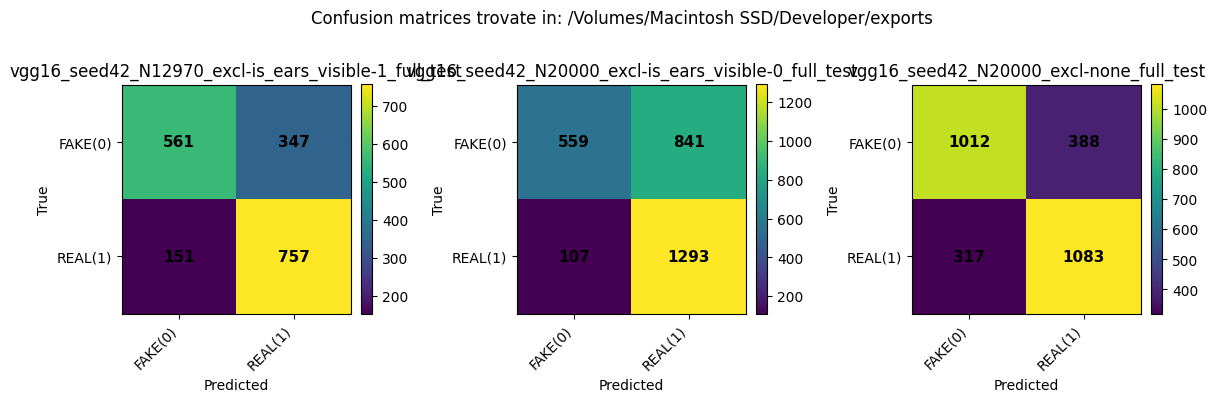

In [183]:
# === Visualizza tutte le confusion matrix salvate in EXPORT_DIR ===
from pathlib import Path
import numpy as np
import math
import matplotlib.pyplot as plt

# Configura qui la cartella di export
EXPORT_DIR = Path("/Volumes/Macintosh SSD/Developer/exports")

# Opzioni di visualizzazione
NORMALIZE = False   # True per mostrare anche le percentuali riga-normalizzate
MAX_COLS   = 3      # numero massimo di colonne nella griglia

# Trova tutti i file delle confusion matrix
cm_paths = sorted(EXPORT_DIR.glob("*_confusion_matrix.npy"))

if not cm_paths:
    print(f"Nessuna confusion matrix trovata in: {EXPORT_DIR}")
else:
    n = len(cm_paths)
    ncols = min(MAX_COLS, n)
    nrows = math.ceil(n / ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))
    if nrows == 1 and ncols == 1:
        axes = np.array([[axes]])
    elif nrows == 1:
        axes = np.array([axes])
    elif ncols == 1:
        axes = axes.reshape(nrows, 1)

    for i, cm_path in enumerate(cm_paths):
        r, c = divmod(i, ncols)
        ax = axes[r, c]

        try:
            cm = np.load(cm_path)
            if cm.shape != (2,2):
                raise ValueError(f"Forma inattesa {cm.shape} (atteso 2x2)")

            # Titolo leggibile dal filename (senza estensione)
            title = cm_path.stem.replace("_confusion_matrix", "")

            # immagine
            im = ax.imshow(cm)

            # ticks e labels
            ax.set_xticks([0,1]); ax.set_yticks([0,1])
            ax.set_xticklabels(["FAKE(0)","REAL(1)"], rotation=45, ha="right")
            ax.set_yticklabels(["FAKE(0)","REAL(1)"])
            ax.set_xlabel("Predicted"); ax.set_ylabel("True")
            ax.set_title(title)

            # annotazioni (conte)
            for rr in range(2):
                for cc in range(2):
                    ax.text(cc, rr, f"{int(cm[rr,cc])}", ha="center", va="center", fontsize=11, weight="bold")

            # percentuali normalizzate per riga (opzionale)
            if NORMALIZE:
                row_sums = cm.sum(axis=1, keepdims=True).astype(float)
                with np.errstate(invalid="ignore", divide="ignore"):
                    cm_pct = np.where(row_sums>0, cm / row_sums, 0.0)
                # mostra percentuali sotto ai conteggi
                for rr in range(2):
                    for cc in range(2):
                        pct = cm_pct[rr, cc] * 100.0
                        ax.text(cc, rr, f"\n{pct:.1f}%", ha="center", va="center", fontsize=9, color="black")

            # colorbar per ogni plot (compatta)
            fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

        except Exception as e:
            ax.axis("off")
            ax.set_title(f"Errore: {cm_path.name}\n{e}", fontsize=10)

    # Nasconde assi extra se #file non riempie la griglia
    for j in range(n, nrows*ncols):
        r, c = divmod(j, ncols)
        axes[r, c].axis("off")

    fig.suptitle(f"Confusion matrices trovate in: {EXPORT_DIR}", y=0.995)
    plt.tight_layout()
    plt.show()


Run trovati: ['vgg16_seed42_N20000_excl-gender-FEMALE_full_test', 'vgg16_seed42_N20000_excl-gender-MALE_full_test', 'vgg16_seed42_N20000_excl-none_full_test']
Attributi: ['ethnicity', 'gender', 'hair_color', 'hair_length', 'is_ears_visible']


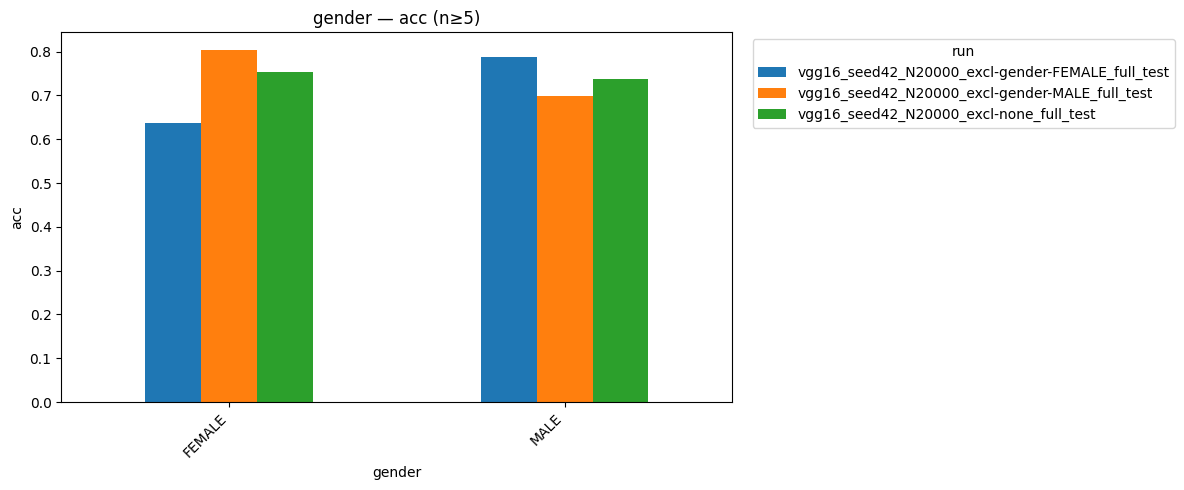

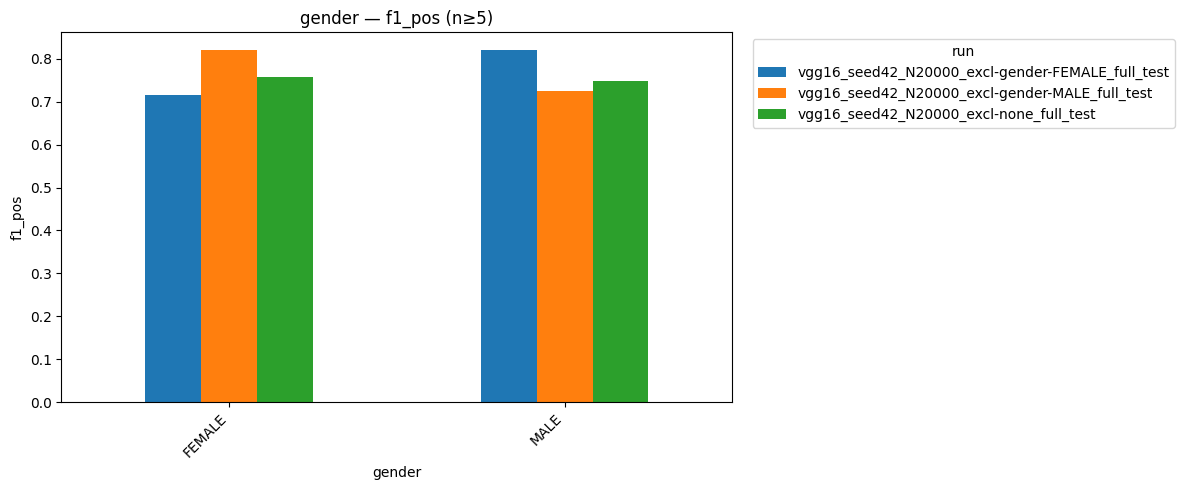

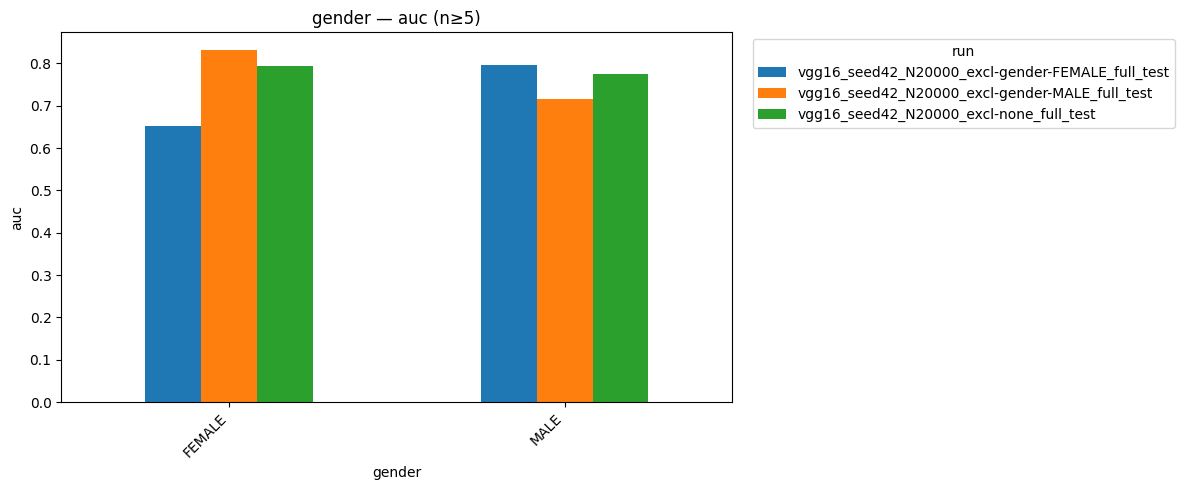

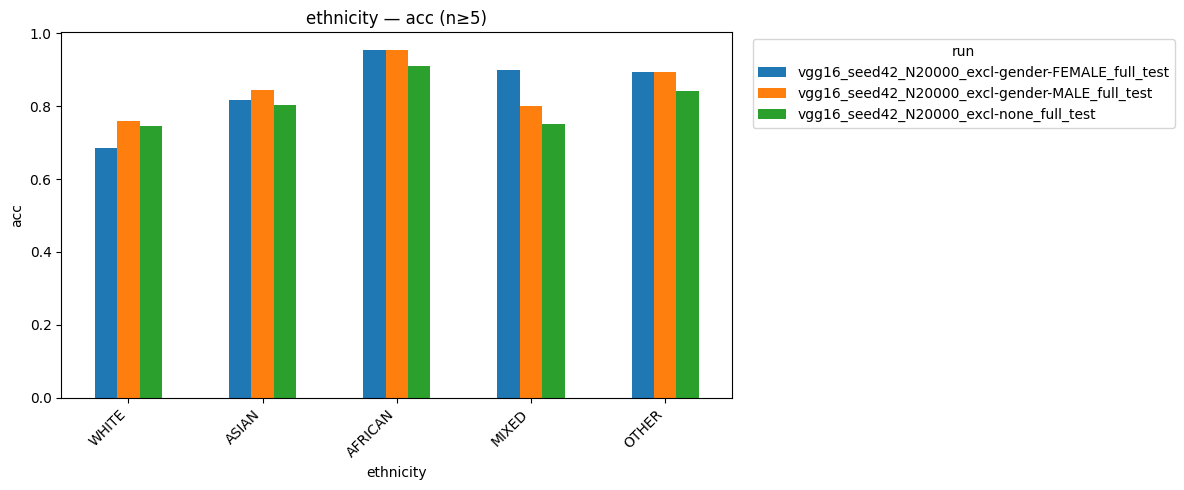

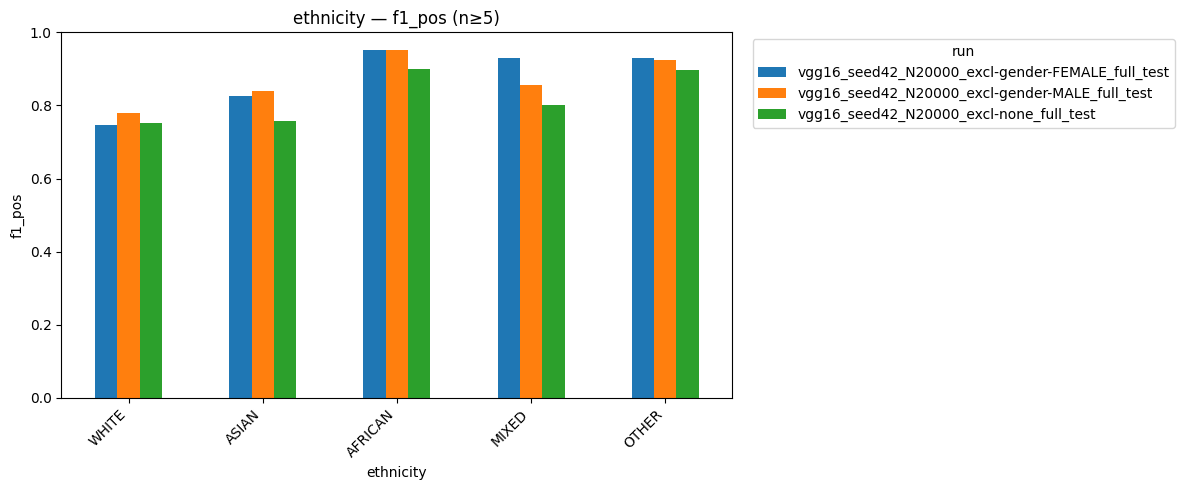

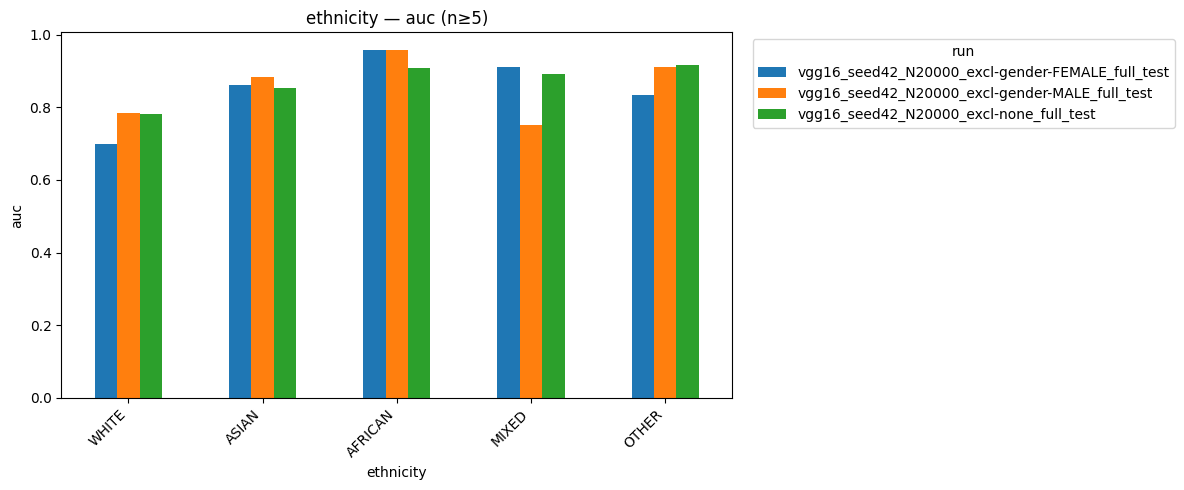

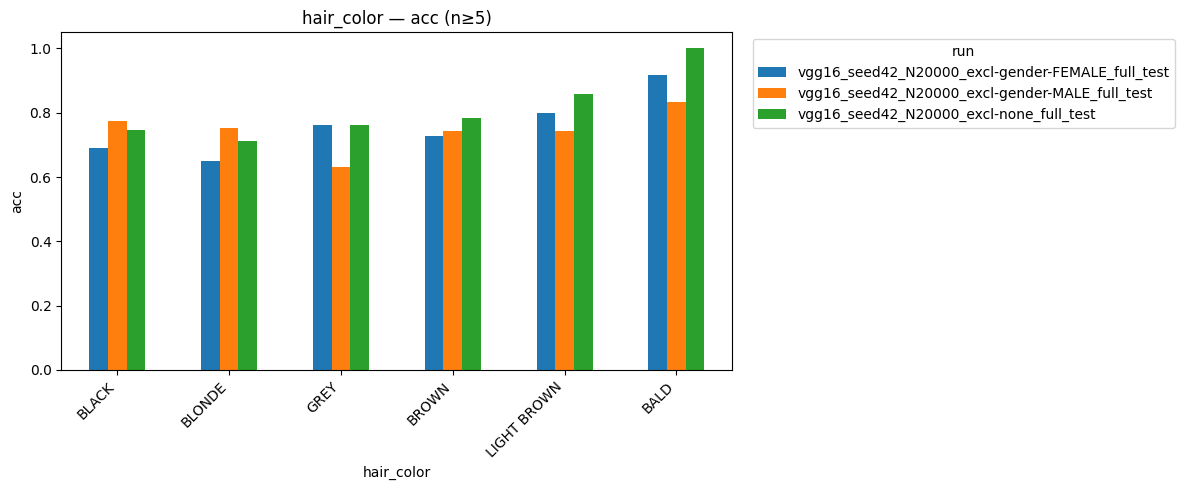

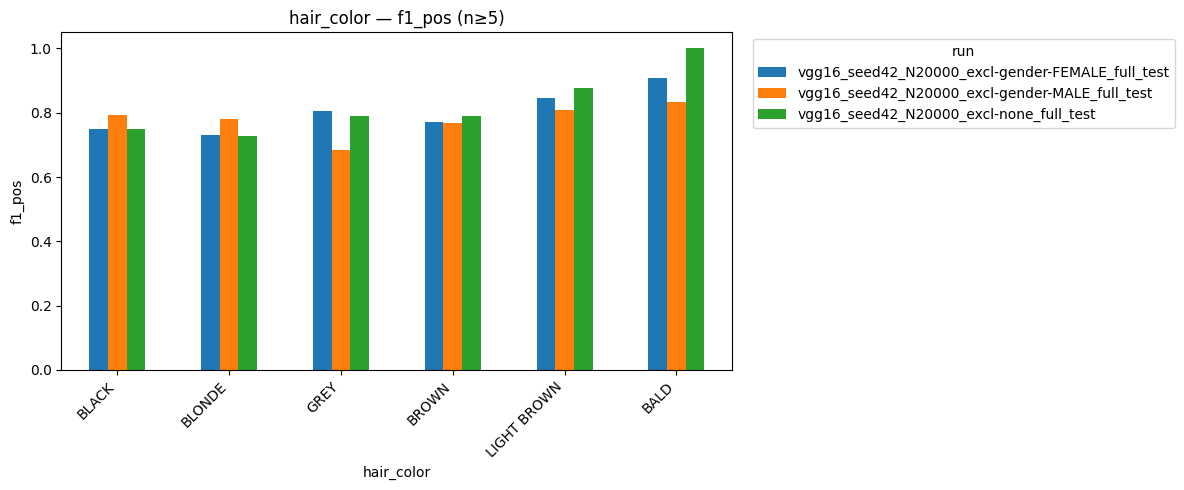

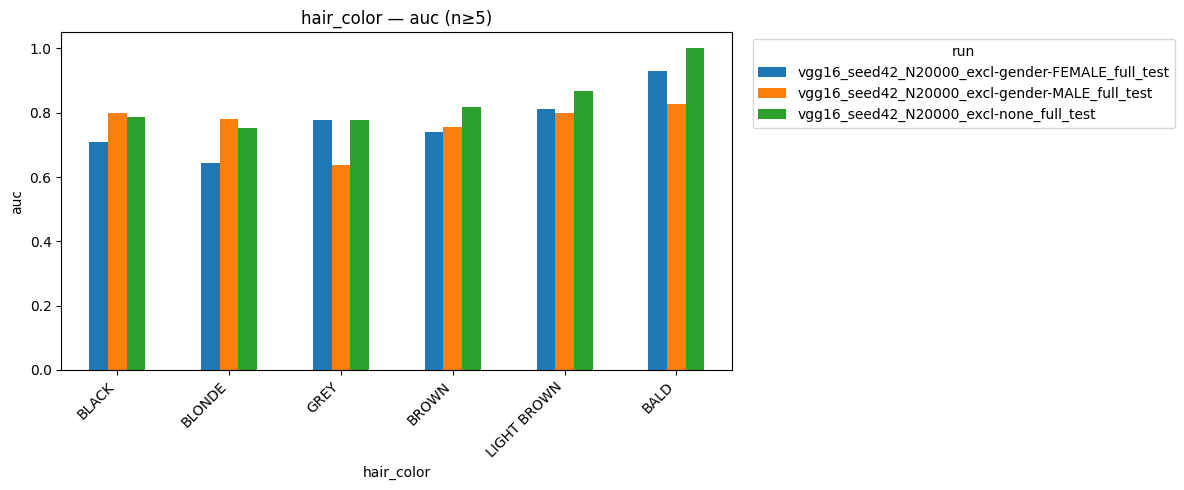

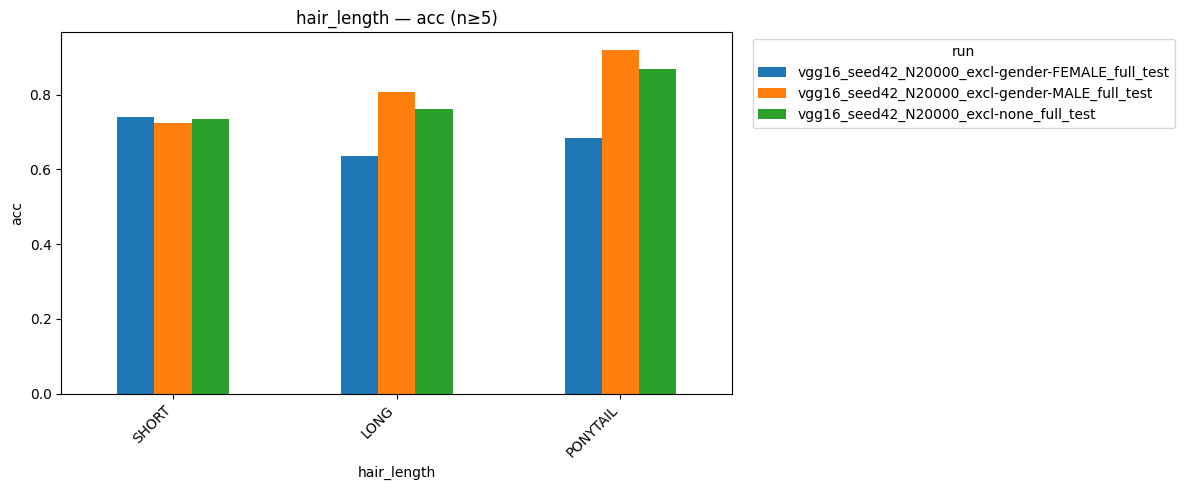

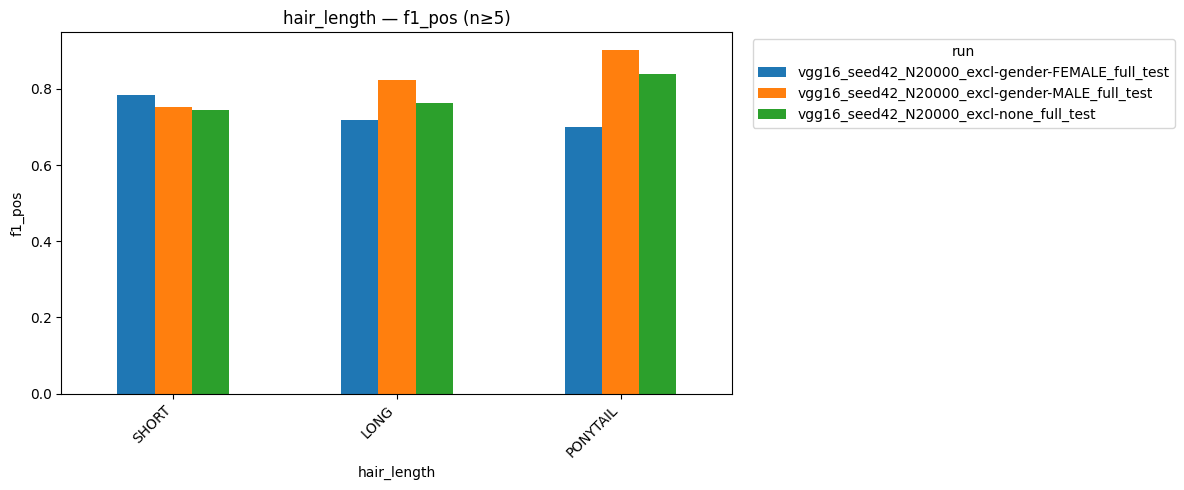

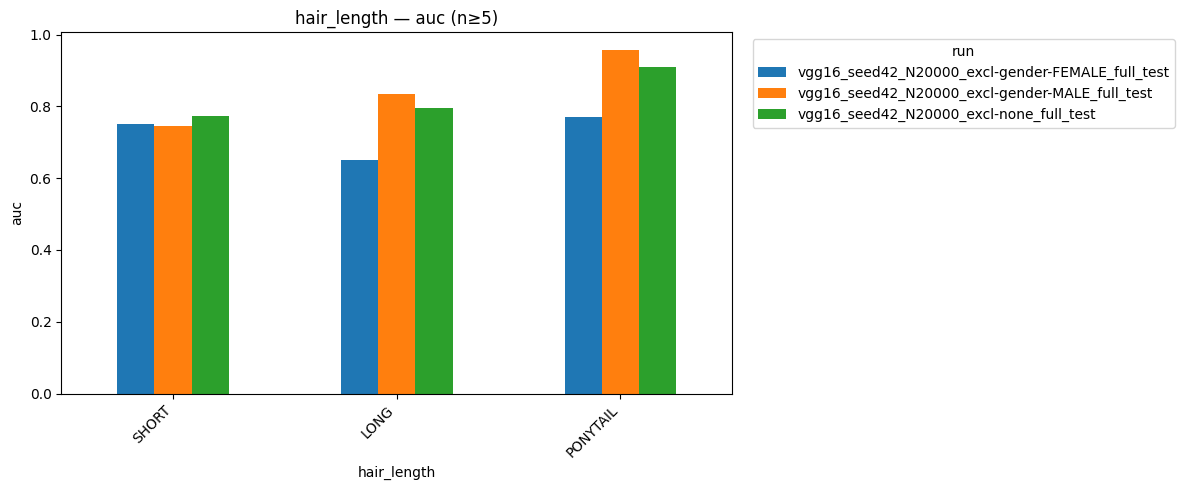

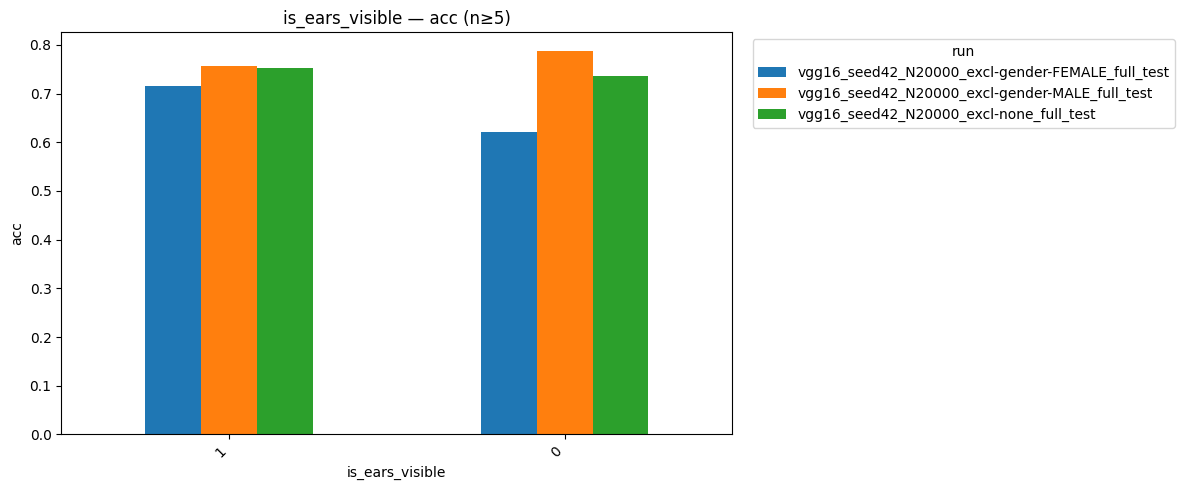

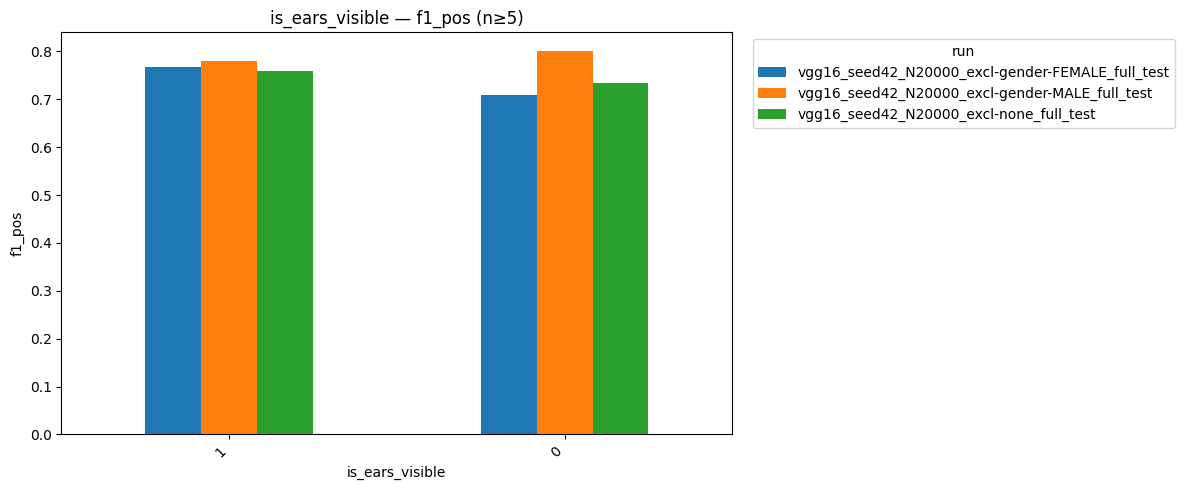

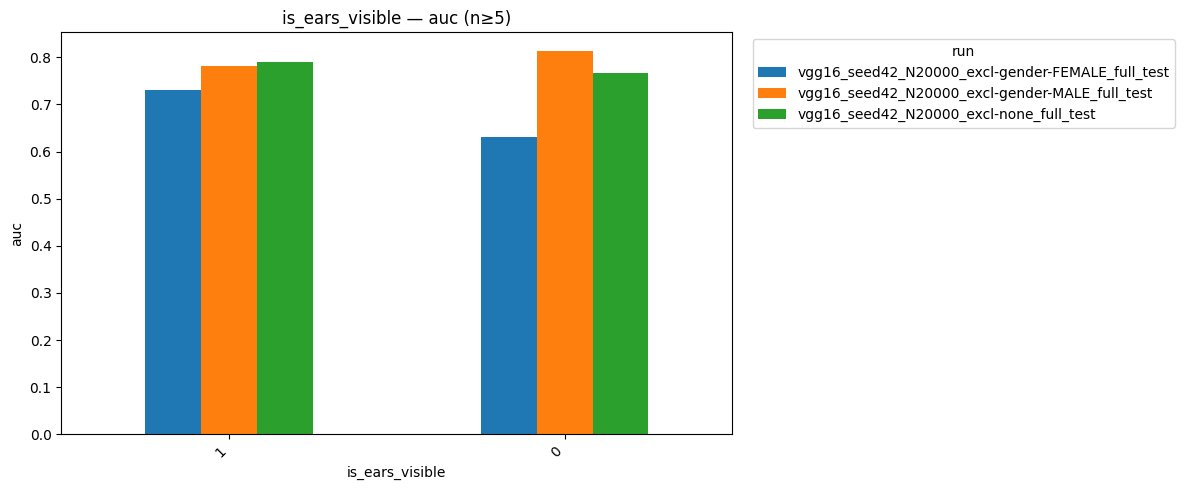


[OK] Grafici salvati:
 - /Volumes/Macintosh SSD/Developer/exports/compare_gender_acc.png
 - /Volumes/Macintosh SSD/Developer/exports/compare_gender_f1_pos.png
 - /Volumes/Macintosh SSD/Developer/exports/compare_gender_auc.png
 - /Volumes/Macintosh SSD/Developer/exports/compare_ethnicity_acc.png
 - /Volumes/Macintosh SSD/Developer/exports/compare_ethnicity_f1_pos.png
 - /Volumes/Macintosh SSD/Developer/exports/compare_ethnicity_auc.png
 - /Volumes/Macintosh SSD/Developer/exports/compare_hair_color_acc.png
 - /Volumes/Macintosh SSD/Developer/exports/compare_hair_color_f1_pos.png
 - /Volumes/Macintosh SSD/Developer/exports/compare_hair_color_auc.png
 - /Volumes/Macintosh SSD/Developer/exports/compare_hair_length_acc.png
 - /Volumes/Macintosh SSD/Developer/exports/compare_hair_length_f1_pos.png
 - /Volumes/Macintosh SSD/Developer/exports/compare_hair_length_auc.png
 - /Volumes/Macintosh SSD/Developer/exports/compare_is_ears_visible_acc.png
 - /Volumes/Macintosh SSD/Developer/exports/compa

In [182]:
# --- Confronta grafici possibili bias ---

# === Confronto bias_by_subgroup di più run e grafici comparativi ===
from pathlib import Path
import pandas as pd
import numpy as np

# -- import/installa matplotlib se assente
try:
    import matplotlib.pyplot as plt
except ModuleNotFoundError:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "matplotlib"])
    import matplotlib.pyplot as plt

# ----- Config -----
EXPORT_DIR = Path("/Volumes/Macintosh SSD/Developer/exports")
MIN_N = 5   # scarta sottogruppi troppo piccoli per stabilità dei grafici
METRICS = ["acc", "f1_pos", "auc"]

# ----- Caricamento di tutti i CSV *_bias_by_subgroup.csv -----
csv_paths = sorted(EXPORT_DIR.glob("*_bias_by_subgroup.csv"))
if not csv_paths:
    raise FileNotFoundError(f"Nessun *_bias_by_subgroup.csv trovato in {EXPORT_DIR}")

dfs = []
for p in csv_paths:
    # run label dal nome file, senza suffisso
    run_label = p.stem.replace("_bias_by_subgroup", "")
    try:
        df_ = pd.read_csv(p)
    except Exception as e:
        print(f"[WARN] Impossibile leggere {p.name}: {e}")
        continue

    # coerenza colonne attese
    missing = set(["attribute","value","n","acc","f1_pos","auc"]) - set(df_.columns)
    if missing:
        print(f"[WARN] {p.name} manca colonne: {missing} -> salto")
        continue

    df_["run"] = run_label
    dfs.append(df_)

if not dfs:
    raise RuntimeError("Nessun CSV valido da analizzare.")

df_all = pd.concat(dfs, axis=0, ignore_index=True)

# cast tipologie
df_all["n"] = pd.to_numeric(df_all["n"], errors="coerce").fillna(0).astype(int)
for m in METRICS:
    df_all[m] = pd.to_numeric(df_all[m], errors="coerce")

# filtro sottogruppi con pochi esempi
df_plot = df_all[df_all["n"] >= MIN_N].copy()
if df_plot.empty:
    raise RuntimeError(f"Tutti i sottogruppi hanno n < {MIN_N}. Abbassa MIN_N.")

print("Run trovati:", sorted(df_plot["run"].unique()))
print("Attributi:", sorted(df_plot["attribute"].unique()))

# ----- Grafici comparativi per attributo/valore -----
# Per ogni attributo, per ciascuna metrica, facciamo un barplot con le barre per run
out_imgs = []
for attr in df_plot["attribute"].unique():
    df_attr = df_plot[df_plot["attribute"] == attr].copy()

    # ordina i valori per dimensione del sottogruppo (media sui run)
    order = (
        df_attr.groupby("value")["n"]
        .mean()
        .sort_values(ascending=False)
        .index.tolist()
    )
    for metric in METRICS:
        pivot = (
            df_attr.pivot_table(index="value", columns="run", values=metric, aggfunc="mean")
            .reindex(order)
        )

        # disegna
        ax = pivot.plot(kind="bar", figsize=(12, 5))
        ax.set_title(f"{attr} — {metric} (n≥{MIN_N})")
        ax.set_xlabel(attr)
        ax.set_ylabel(metric)
        ax.legend(title="run", bbox_to_anchor=(1.02, 1), loc="upper left")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()

        out_path = EXPORT_DIR / f"compare_{attr}_{metric}.png"
        plt.savefig(out_path, dpi=150)
        plt.show()
        out_imgs.append(out_path)

print("\n[OK] Grafici salvati:")
for p in out_imgs:
    print(" -", p)

# ----- (Opzionale) Tabella differenze se ci sono esattamente due run -----
runs = sorted(df_plot["run"].unique())
if len(runs) == 2:
    run_a, run_b = runs
    print(f"\nCalcolo differenze ( {run_b} - {run_a} ) per ciascun valore/metrica...")

    diffs = []
    for attr in df_plot["attribute"].unique():
        sub = df_plot[df_plot["attribute"] == attr]
        # media per (run, value) per metrica
        grp = sub.groupby(["run", "value"])[METRICS].mean().reset_index()
        wide = grp.pivot(index="value", columns="run", values=METRICS)
        # calcola differenze run_b - run_a per ogni metrica
        for metric in METRICS:
            if (metric, run_a) in wide.columns and (metric, run_b) in wide.columns:
                diff_series = wide[(metric, run_b)] - wide[(metric, run_a)]
                for val, d in diff_series.dropna().items():
                    # n medio per contesto
                    n_mean = int(
                        df_plot[(df_plot["attribute"] == attr) & (df_plot["value"] == val)]
                        ["n"].mean()
                    )
                    diffs.append([attr, val, n_mean, metric, float(d)])

    if diffs:
        diffs_df = pd.DataFrame(diffs, columns=["attribute","value","n_mean","metric","delta_runB_minus_runA"])
        diffs_path = EXPORT_DIR / f"diffs_{run_b}_minus_{run_a}.csv"
        diffs_df.sort_values(["attribute","metric","n_mean"], ascending=[True, True, False], inplace=True)
        diffs_df.to_csv(diffs_path, index=False)
        print("Differenze salvate in:", diffs_path)
    else:
        print("[INFO] Impossibile calcolare differenze (dati incompleti?).")
else:
    print("\n[INFO] Skipping differenze: numero run ≠ 2.")


Trovati 3 metrics.json


,file,seed,N_total,eval_loss,eval_acc,eval_auc,acc,precision_micro,recall_micro,f1_micro,precision_macro,recall_macro,f1_macro,auc_global,n_test,exclusions
experiment,,,,,,,,,,,,,,,,
vgg16_seed42_N20000_excl-none_full_test,/Volumes/Macintosh SSD/Developer/exports/vgg16...,42,20000,3.2671,0.7482,0.7654,0.7482,NaN,NaN,0.7482,NaN,NaN,0.7481,0.7857,2800,unknown
vgg16_seed42_N12970_excl-is_ears_visible-1_full_test,/Volumes/Macintosh SSD/Developer/exports/vgg16...,42,12970,3.6259,0.7258,0.7470,0.7258,NaN,NaN,0.7258,NaN,NaN,0.7225,0.7590,1816,unknown
vgg16_seed42_N20000_excl-is_ears_visible-0_full_test,/Volumes/Macintosh SSD/Developer/exports/vgg16...,42,20000,5.0523,0.6614,0.6690,0.6614,NaN,NaN,0.6614,NaN,NaN,0.6364,0.6761,2800,unknown


Salvato CSV: /Volumes/Macintosh SSD/Developer/exports/compare_all_metrics.csv

Top 5 per acc:


,acc,auc_global,f1_macro,exclusions,seed,N_total
experiment,,,,,,
vgg16_seed42_N20000_excl-none_full_test,0.7482,0.7857,0.7481,unknown,42,20000
vgg16_seed42_N12970_excl-is_ears_visible-1_full_test,0.7258,0.7590,0.7225,unknown,42,12970
vgg16_seed42_N20000_excl-is_ears_visible-0_full_test,0.6614,0.6761,0.6364,unknown,42,20000



Top 5 per auc_global:


,auc_global,f1_macro,exclusions,seed,N_total
experiment,,,,,
vgg16_seed42_N20000_excl-none_full_test,0.7857,0.7481,unknown,42,20000
vgg16_seed42_N12970_excl-is_ears_visible-1_full_test,0.7590,0.7225,unknown,42,12970
vgg16_seed42_N20000_excl-is_ears_visible-0_full_test,0.6761,0.6364,unknown,42,20000


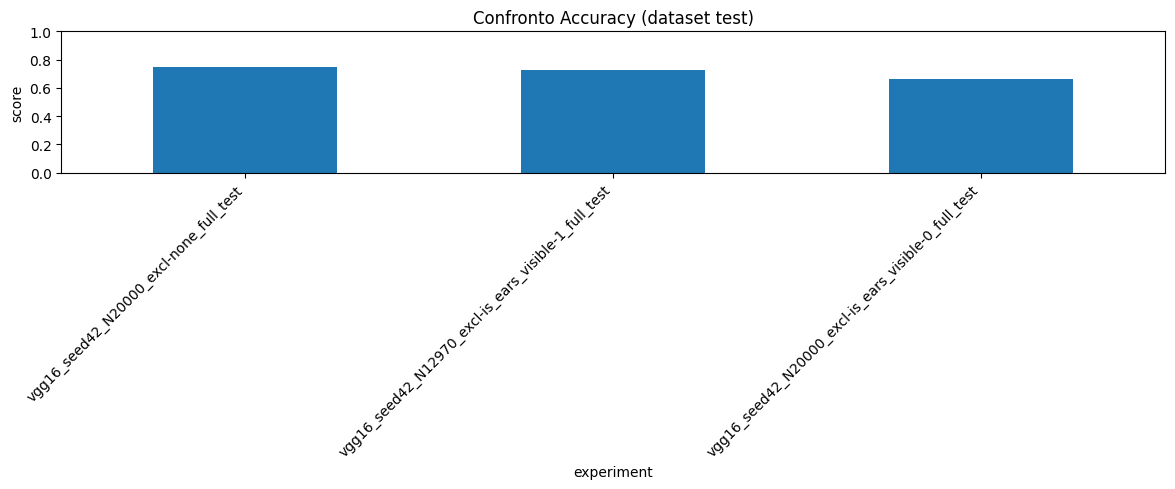

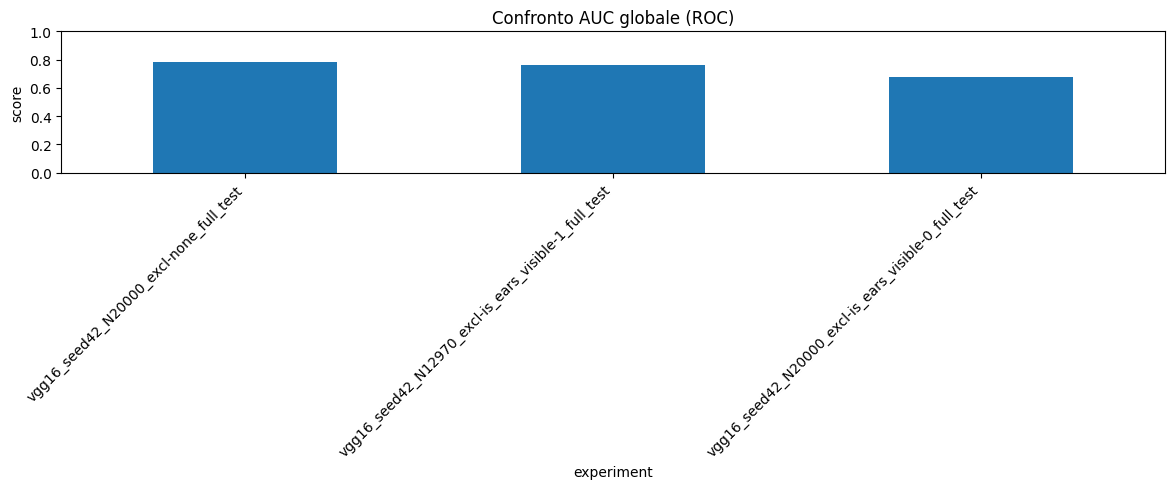

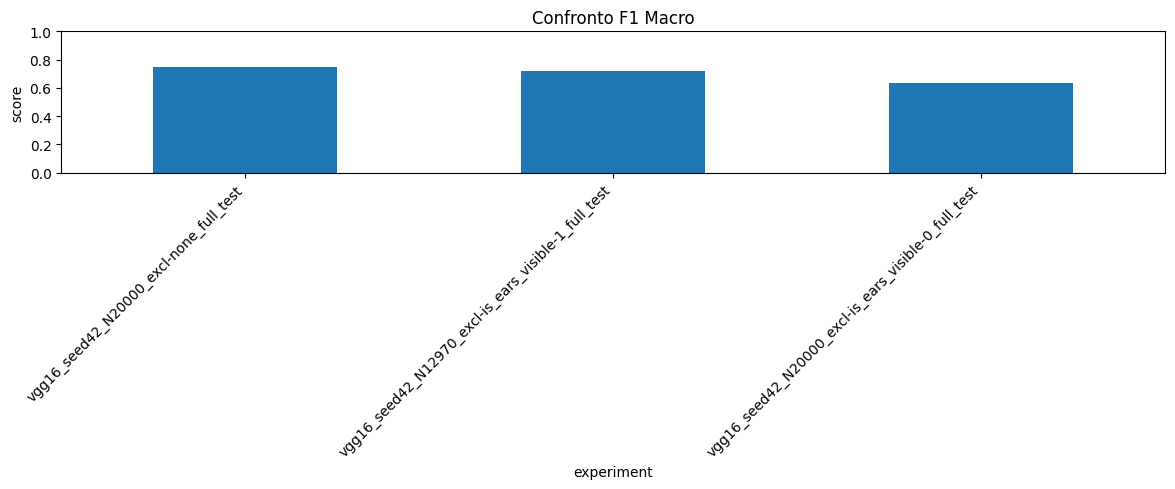

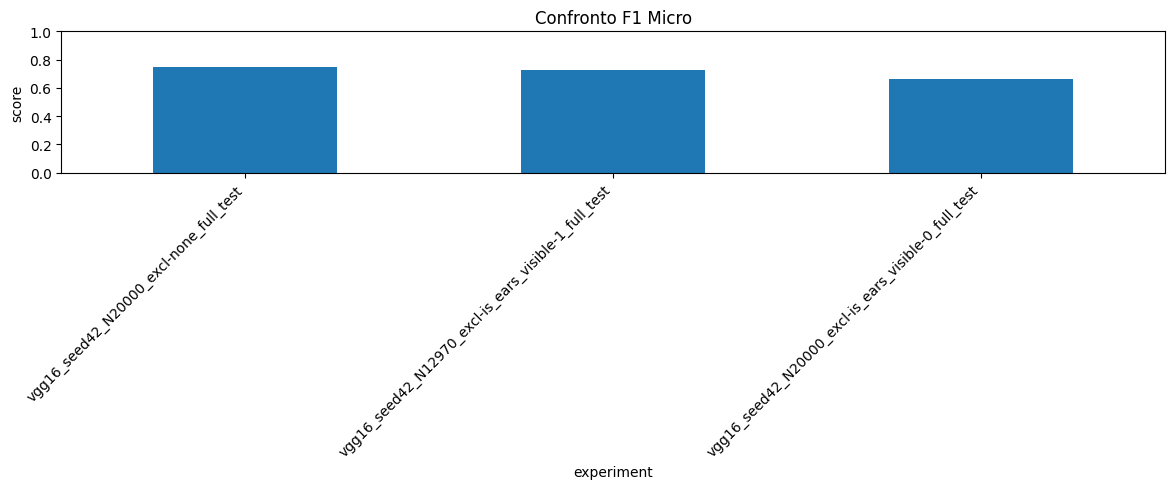

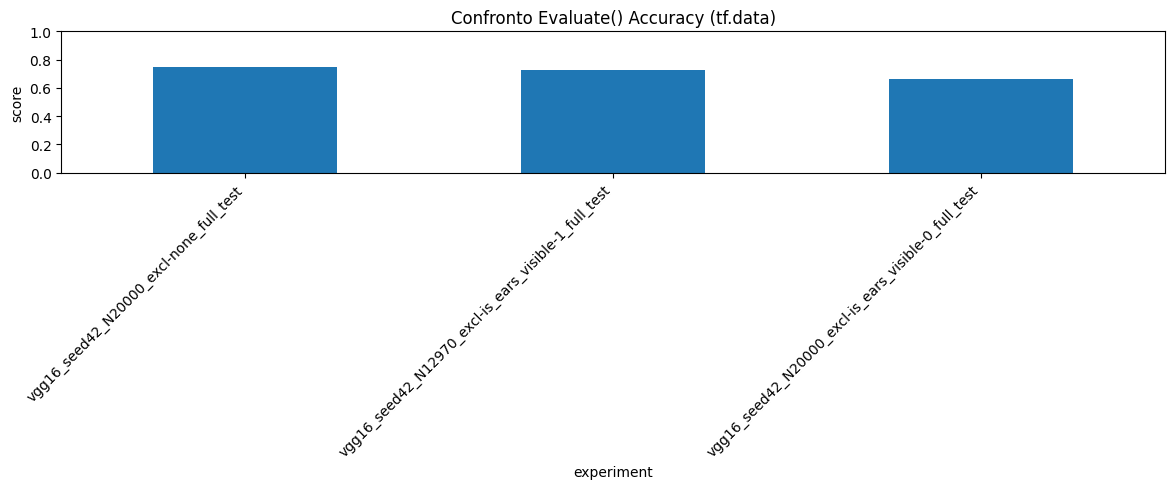

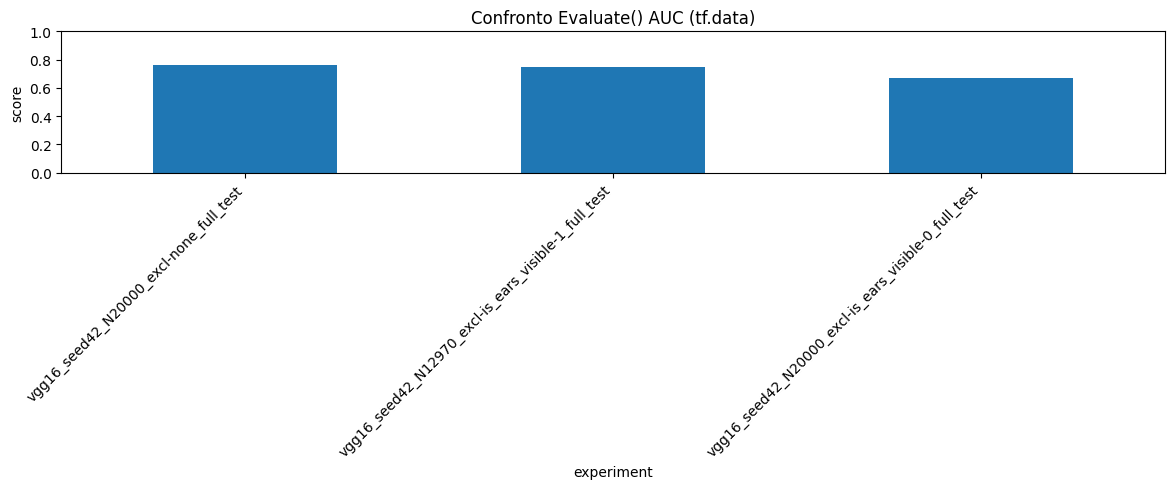

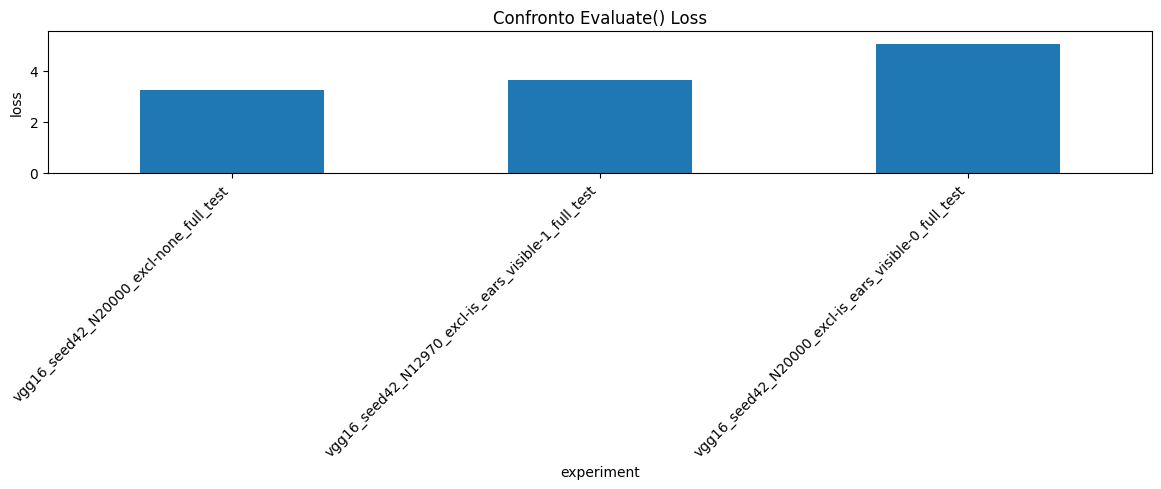


Media metriche per 'exclusions':


,acc,auc_global,f1_macro,f1_micro,eval_loss,eval_acc,eval_auc
exclusions,,,,,,,
unknown,0.7118,0.7403,0.7023,0.7118,3.9818,0.7118,0.7271


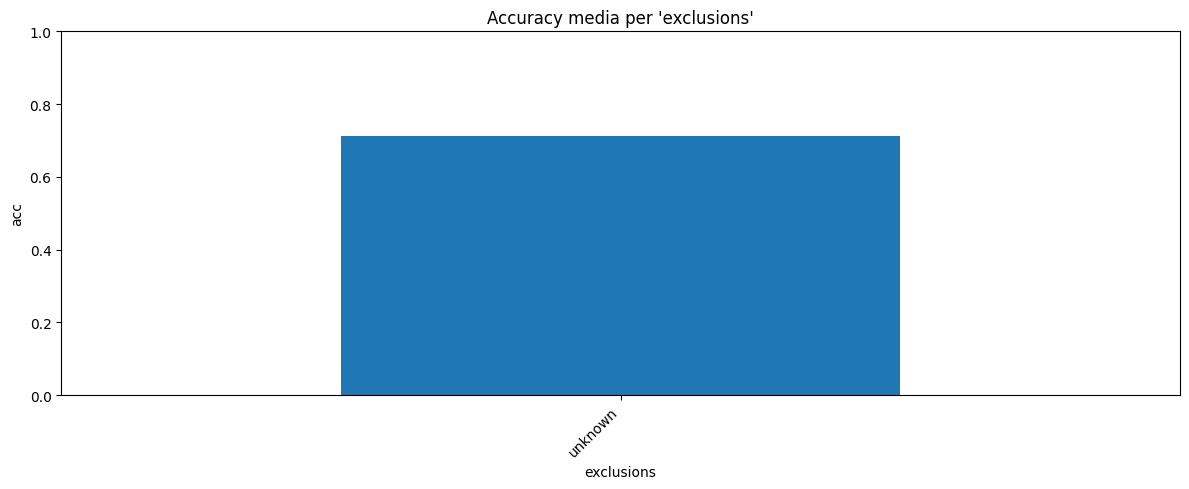

In [145]:
from pathlib import Path
import json
import re
import pandas as pd
import numpy as np

# --- Config ---
EXPORT_DIR = Path("/Volumes/Macintosh SSD/Developer/exports")

# --- Matplotlib opzionale (se non presente, salta i grafici) ---
try:
    import matplotlib.pyplot as plt
    HAS_MPL = True
except Exception:
    HAS_MPL = False
    print("[INFO] matplotlib non disponibile, salterò i grafici. (pip install matplotlib)")

# --- Raccolta di tutti i *_metrics.json ---
files = sorted(EXPORT_DIR.glob("*_metrics.json"))
print(f"Trovati {len(files)} metrics.json")
if not files:
    raise FileNotFoundError(f"Nessun *_metrics.json in {EXPORT_DIR}")

rows = []
pat_seed = re.compile(r"seed(\d+)")
pat_N    = re.compile(r"_N(\d+)")

for fp in files:
    try:
        with fp.open() as f:
            data = json.load(f)
    except Exception as e:
        print(f"[WARN] Impossibile leggere {fp.name}: {e}")
        continue

    stem = fp.stem  # es: vgg16_seed42_N20000_excl-none_metrics
    exp_name = stem.replace("_metrics", "")

    # prova a ricavare seed e N dal nome file
    seed_m = pat_seed.search(stem)
    N_m    = pat_N.search(stem)
    seed   = int(seed_m.group(1)) if seed_m else None
    Ntot   = int(N_m.group(1)) if N_m else None

    rows.append({
        "experiment": exp_name,
        "file": str(fp),
        "seed": seed,
        "N_total": Ntot,
        "eval_loss": float(data.get("eval_loss", np.nan)),
        "eval_acc": float(data.get("eval_acc", np.nan)),
        "eval_auc": float(data.get("eval_auc", np.nan)),
        "acc": float(data.get("acc", np.nan)),
        "precision_micro": float(data.get("precision_micro", np.nan)),
        "recall_micro": float(data.get("recall_micro", np.nan)),
        "f1_micro": float(data.get("f1_micro", np.nan)),
        "precision_macro": float(data.get("precision_macro", np.nan)),
        "recall_macro": float(data.get("recall_macro", np.nan)),
        "f1_macro": float(data.get("f1_macro", np.nan)),
        "auc_global": float(data.get("auc_global", np.nan)),
        "n_test": int(data.get("n_test", 0)) if data.get("n_test") is not None else np.nan,
        "exclusions": data.get("exclusions", "unknown"),
    })

df = pd.DataFrame(rows).set_index("experiment").sort_values("acc", ascending=False)
display(df.round(4))

# --- Salva CSV complessivo ---
out_csv = EXPORT_DIR / "compare_all_metrics.csv"
df.to_csv(out_csv)
print("Salvato CSV:", out_csv)

# --- Top K (corretto: evita colonne duplicate) ---
def top_k(col, k=5):
    if col not in df.columns: 
        print(f"[WARN] Colonna {col} assente")
        return
    print(f"\nTop {k} per {col}:")
    cols_show = [c for c in ["auc_global","f1_macro","exclusions","seed","N_total"] if c in df.columns]
    sel = [col] + [c for c in cols_show if c != col]           # evita duplicati
    sel = list(dict.fromkeys(sel))                              # dedup definitivo
    display(df[sel].sort_values(col, ascending=False).head(k).round(4))

top_k("acc", 5)
top_k("auc_global", 5)

# --- Grafici (se possibile) ---
def plot_bar(series, title, ylabel="score", ylim=None, rotation=45):
    if not HAS_MPL: 
        return
    plt.figure(figsize=(12, 5))
    series.plot(kind="bar")
    plt.title(title)
    plt.ylabel(ylabel)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xticks(rotation=rotation, ha="right")
    plt.tight_layout()
    plt.show()

# metriche principali 0..1
for col, ttl in [
    ("acc", "Accuracy (dataset test)"),
    ("auc_global", "AUC globale (ROC)"),
    ("f1_macro", "F1 Macro"),
    ("f1_micro", "F1 Micro"),
    ("eval_acc", "Evaluate() Accuracy (tf.data)"),
    ("eval_auc", "Evaluate() AUC (tf.data)")
]:
    if col in df.columns:
        plot_bar(df[col], f"Confronto {ttl}", ylim=(0, 1.0))

# loss (scala libera)
if "eval_loss" in df.columns:
    vmax = float(df["eval_loss"].max()) if len(df) else 1.0
    plot_bar(df["eval_loss"], "Confronto Evaluate() Loss", ylabel="loss", ylim=(0, max(1.0, vmax*1.1)))

# --- (Opzionale) confronto per exclusions ---
if "exclusions" in df.columns:
    by_excl = (df.groupby("exclusions")[["acc","auc_global","f1_macro","f1_micro","eval_loss","eval_acc","eval_auc"]]
                  .mean().sort_values("acc", ascending=False))
    print("\nMedia metriche per 'exclusions':")
    display(by_excl.round(4))
    if HAS_MPL:
        plt.figure(figsize=(12,5))
        by_excl["acc"].plot(kind="bar")
        plt.title("Accuracy media per 'exclusions'")
        plt.ylabel("acc")
        plt.ylim(0,1.0)
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()


### DEBUG: Semple frames excluded

Applico filtro gender in ['FEMALE']

Trovati 34322 frames che soddisfano tutti i criteri di esclusione
Di cui:
- REAL: 17248
- FAKE: 17074


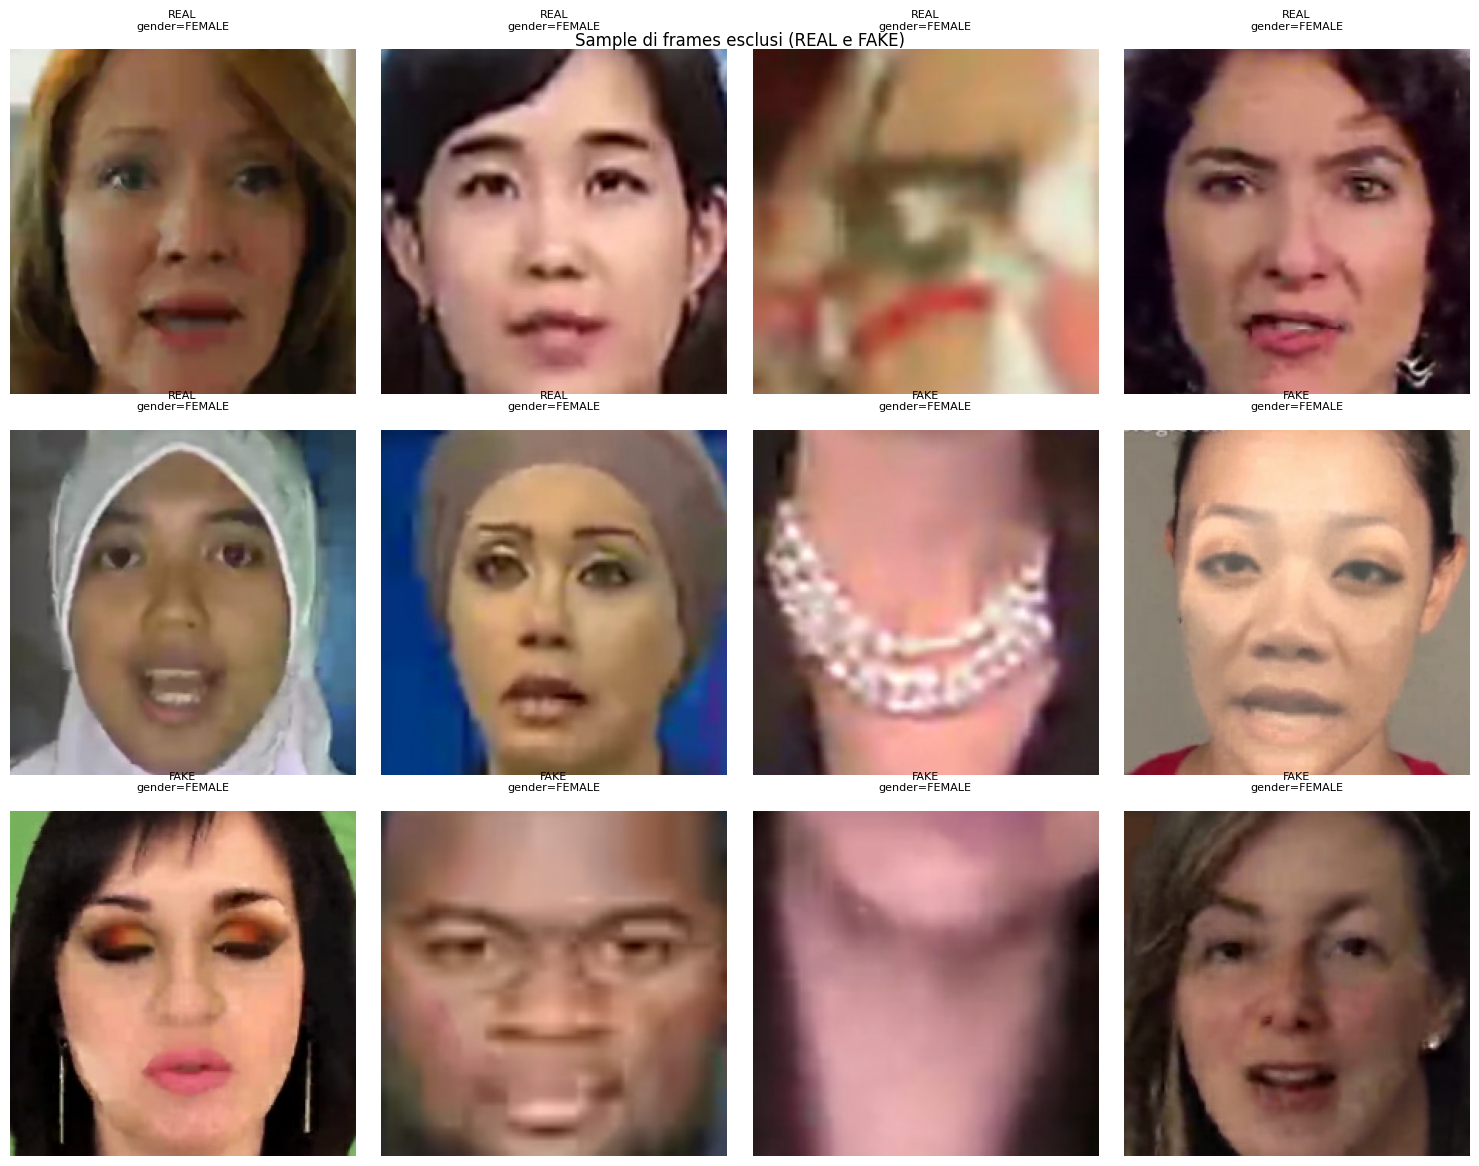


REAL frames visualizzati:
 - /Volumes/Macintosh SSD/FaceForensics_c40/original_sequences/youtube/c40/faces/439_000_face0.jpeg
 - /Volumes/Macintosh SSD/FaceForensics_c40/original_sequences/youtube/c40/faces/503_100_face0.jpeg
 - /Volumes/Macintosh SSD/FaceForensics_c40/original_sequences/youtube/c40/faces/477_140_face1.jpeg
 - /Volumes/Macintosh SSD/FaceForensics_c40/original_sequences/youtube/c40/faces/783_160_face0.jpeg
 - /Volumes/Macintosh SSD/FaceForensics_c40/original_sequences/youtube/c40/faces/808_520_face0.jpeg
 - /Volumes/Macintosh SSD/FaceForensics_c40/original_sequences/youtube/c40/faces/954_080_face0.jpeg

FAKE frames visualizzati:
 - /Volumes/Macintosh SSD/FaceForensics_c40/manipulated_sequences/Deepfakes/c40/faces/824_419_200_face2.jpeg
 - /Volumes/Macintosh SSD/FaceForensics_c40/manipulated_sequences/Deepfakes/c40/faces/508_831_320_face0.jpeg
 - /Volumes/Macintosh SSD/FaceForensics_c40/manipulated_sequences/Deepfakes/c40/faces/121_093_220_face0.jpeg
 - /Volumes/Macinto

In [180]:
# === Visualizza 6+6 frames REAL/FAKE tra quelli esclusi ===
import matplotlib.pyplot as plt
import tensorflow as tf
from pathlib import Path
import numpy as np
import pandas as pd

def load_and_preprocess_image(path, target_size=(224, 224)):
    """Carica un'immagine da file system"""
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, target_size)
    img = tf.cast(img, tf.float32) / 255.0
    return img.numpy()

# 1. Verifica che df contenga le colonne necessarie
required_cols = ['path', 'is_real'] + list(EXCLUDE.keys())
missing = [col for col in required_cols if col not in df.columns]
if missing:
    raise KeyError(f"Mancano le colonne: {missing}. Esegui prima i blocchi 3B e 4.")

# 2. Trova i frames che soddisfano TUTTI i criteri di esclusione
mask_excluded = pd.Series(True, index=df.index)
for col, bad_vals in EXCLUDE.items():
    if col in df.columns:
        mask_excluded &= df[col].astype(str).isin(bad_vals)
        print(f"Applico filtro {col} in {bad_vals}")
    else:
        print(f"[WARN] Colonna {col} non trovata")

df_excluded = df[mask_excluded].copy()
print(f"\nTrovati {len(df_excluded)} frames che soddisfano tutti i criteri di esclusione")

if len(df_excluded) == 0:
    print("Nessun frame escluso con i criteri attuali.")
else:
    # 3. Separa REAL e FAKE
    df_real = df_excluded[df_excluded["is_real"] == 1]
    df_fake = df_excluded[df_excluded["is_real"] == 0]
    
    print(f"Di cui:\n- REAL: {len(df_real)}\n- FAKE: {len(df_fake)}")

    # 4. Seleziona 6 frames casuali da ciascuno (o meno se non disponibili)
    n_show = 6
    real_samples = df_real.sample(n=min(n_show, len(df_real)), random_state=SEED)
    fake_samples = df_fake.sample(n=min(n_show, len(df_fake)), random_state=SEED)
    
    # 5. Plot 4x3 (primi 6 REAL, poi 6 FAKE)
    fig, axes = plt.subplots(3, 4, figsize=(15, 12))
    axes = axes.ravel()

    # Plot REAL
    for i, (_, row) in enumerate(real_samples.iterrows()):
        try:
            img = load_and_preprocess_image(row["path"])
            axes[i].imshow(img)
            
            # Caption con attributi esclusi
            caption = "REAL\n"
            for col in EXCLUDE.keys():
                if col in row:
                    caption += f"{col}={row[col]}\n"
            
            axes[i].set_title(caption, fontsize=8)
        except Exception as e:
            axes[i].text(0.5, 0.5, f"Errore:\n{str(e)}", 
                        ha='center', va='center', fontsize=8,
                        transform=axes[i].transAxes)
        axes[i].axis("off")

    # Plot FAKE
    for i, (_, row) in enumerate(fake_samples.iterrows(), start=6):
        try:
            img = load_and_preprocess_image(row["path"])
            axes[i].imshow(img)
            
            # Caption con attributi esclusi
            caption = "FAKE\n"
            for col in EXCLUDE.keys():
                if col in row:
                    caption += f"{col}={row[col]}\n"
            
            axes[i].set_title(caption, fontsize=8)
        except Exception as e:
            axes[i].text(0.5, 0.5, f"Errore:\n{str(e)}", 
                        ha='center', va='center', fontsize=8,
                        transform=axes[i].transAxes)
        axes[i].axis("off")

    # Nascondi subplot vuoti
    for j in range(len(real_samples) + len(fake_samples), 12):
        axes[j].axis("off")

    plt.suptitle("Sample di frames esclusi (REAL e FAKE)", y=0.95)
    plt.tight_layout()
    plt.show()

    # 6. Stampa paths per debug
    print("\nREAL frames visualizzati:")
    for _, row in real_samples.iterrows():
        print(f" - {row['path']}")
    print("\nFAKE frames visualizzati:") 
    for _, row in fake_samples.iterrows():
        print(f" - {row['path']}")

In [ ]:
from pathlib import Path
import numpy as np

# Directory contenente le confusion matrix
EXPORT_DIR = Path("/Volumes/Macintosh SSD/Developer/exports/FAKE(0)  REAL(1)
[1041    359]  FAKE(0)  # TNR = 74.4%
[324    1076]  REAL(1)  # TPR = 76.8%confusion_matrices")

# Trova tutti i file delle confusion matrix
cm_paths = sorted(EXPORT_DIR.glob("*_confusion_matrix.npy"))

if not cm_paths:
    print(f"Nessuna confusion matrix trovata in: {EXPORT_DIR}")
else:
    for cm_path in cm_paths:
        try:
            # Carica la matrice
            cm = np.load(cm_path)
            
            # Verifica che sia 2x2
            if cm.shape != (2,2):
                print(f"[SKIP] {cm_path.name}: forma non valida {cm.shape}")
                continue
                
            # Crea il testo formattato
            text = f"Confusion Matrix: {cm_path.stem}\n"
            text += "             Predicted\n"
            text += "             FAKE(0)  REAL(1)\n"
            text += f"FAKE(0)     {cm[0,0]:<8} {cm[0,1]}\n"
            text += f"REAL(1)     {cm[1,0]:<8} {cm[1,1]}\n"
            
            # Calcola alcune metriche
            total = cm.sum()
            accuracy = (cm[0,0] + cm[1,1]) / total
            text += f"\nTotal samples: {total}\n"
            text += f"Accuracy: {accuracy:.4f}\n"
            
            # Row-wise percentages
            text += "\nRow percentages:\n"
            row_sums = cm.sum(axis=1, keepdims=True)
            with np.errstate(invalid='ignore', divide='ignore'):
                row_percentages = np.where(row_sums > 0, cm / row_sums * 100, 0)
            text += f"FAKE(0)     {row_percentages[0,0]:.1f}%    {row_percentages[0,1]:.1f}%\n"
            text += f"REAL(1)     {row_percentages[1,0]:.1f}%    {row_percentages[1,1]:.1f}%\n"
            
            # Salva il file di testo
            out_path = cm_path.with_suffix('.txt')
            out_path.write_text(text)
            print(f"Salvato: {out_path}")
            
        except Exception as e:
            print(f"Errore con {cm_path.name}: {e}")

print("\nProcessing completato.")

Salvato: /Volumes/Macintosh SSD/Developer/exports/confusion_matrices/vgg16_seed42_N12970_excl-is_ears_visible-1_full_test_confusion_matrix.txt
Salvato: /Volumes/Macintosh SSD/Developer/exports/confusion_matrices/vgg16_seed42_N20000_excl-hair_length-LONG_full_test_confusion_matrix.txt
Salvato: /Volumes/Macintosh SSD/Developer/exports/confusion_matrices/vgg16_seed42_N20000_excl-hair_length-SHORT_full_test_confusion_matrix.txt
Salvato: /Volumes/Macintosh SSD/Developer/exports/confusion_matrices/vgg16_seed42_N20000_excl-is_ears_visible-0_full_test_confusion_matrix.txt
Salvato: /Volumes/Macintosh SSD/Developer/exports/confusion_matrices/vgg16_seed42_N20000_excl-none_full_test_confusion_matrix.txt

Processing completato.
